In [1]:
import pandas as pd
import datetime
import numpy as np
from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [2]:
%config IPCompleter.greedy = True

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Load the Data

In [4]:
df = pd.read_csv("./RAW_DATA/dublinbus_jan.csv")

### Information on the data

Print the number of rows and columns for the data

In [5]:
print("Rows:" ,df.shape[0])
print("Columns:" ,df.shape[1])

Rows: 50000
Columns: 16


Print the head and tail of the data to examine it in more detail

In [6]:
df.head()

DayOfService   TripID LineId  Direction  TPlannedTime_Arr  \
0  2018-01-01 00:00:00  5955277     16          1             33932   
1  2018-01-01 00:00:00  5955277     16          1             33932   
2  2018-01-01 00:00:00  5955277     16          1             33932   
3  2018-01-01 00:00:00  5955277     16          1             33932   
4  2018-01-01 00:00:00  5955277     16          1             33932   

   TPlannedTime_Dep  TActualTime_Arr  TActualTime_Dep  progrnumber  \
0             30000          33184.0          30029.0           28   
1             30000          33184.0          30029.0           29   
2             30000          33184.0          30029.0           30   
3             30000          33184.0          30029.0           31   
4             30000          33184.0          30029.0           32   

   stoppointid  Lplannedtime_arr  Lplannedtime_dep  Lactualtime_arr  \
0           45             31343             31343            31152   
1           46             31407             31407            31207   
2           47             31484             31484            31281   
3           48             31551             31551            31315   
4           49             31646             31646            31362   

   Lactualtime_dep  vehicleid           lastupdate  
0            31163    1001127  2018-01-08 17:21:10  
1            31239    1001127  2018-01-08 17:21:10  
2            31288    1001127  2018-01-08 17:21:10  
3            31327    1001127  2018-01-08 17:21:10  
4            31439    1001127  2018-01-08 17:21:10

In [7]:
df.tail()

DayOfService   TripID LineId  Direction  TPlannedTime_Arr  \
49995  2018-01-01 00:00:00  5959767     83          2             69259   
49996  2018-01-01 00:00:00  5959767     83          2             69259   
49997  2018-01-01 00:00:00  5959767     83          2             69259   
49998  2018-01-01 00:00:00  5959767     83          2             69259   
49999  2018-01-01 00:00:00  5959767     83          2             69259   

       TPlannedTime_Dep  TActualTime_Arr  TActualTime_Dep  progrnumber  \
49995             65400          68674.0          65469.0           21   
49996             65400          68674.0          65469.0           22   
49997             65400          68674.0          65469.0           23   
49998             65400          68674.0          65469.0           24   
49999             65400          68674.0          65469.0           25   

       stoppointid  Lplannedtime_arr  Lplannedtime_dep  Lactualtime_arr  \
49995         1071             66293             66293            66354   
49996         4528             66348             66348            66382   
49997         1072             66424             66424            66467   
49998         1352             66542             66542            66581   
49999         1353             66596             66596            66645   

       Lactualtime_dep  vehicleid           lastupdate  
49995            66354    2693245  2018-01-08 17:21:10  
49996            66382    2693245  2018-01-08 17:21:10  
49997            66478    2693245  2018-01-08 17:21:10  
49998            66620    2693245  2018-01-08 17:21:10  
49999            66645    2693245  2018-01-08 17:21:10

### Examine the data types

In [8]:
df.dtypes

DayOfService         object
TripID                int64
LineId               object
Direction             int64
TPlannedTime_Arr      int64
TPlannedTime_Dep      int64
TActualTime_Arr     float64
TActualTime_Dep     float64
progrnumber           int64
stoppointid           int64
Lplannedtime_arr      int64
Lplannedtime_dep      int64
Lactualtime_arr       int64
Lactualtime_dep       int64
vehicleid             int64
lastupdate           object
dtype: object

### Reassign the datatypes to suitable forms

In [9]:
categorical_columns = df[['LineId', 'Direction']].columns
continuous_columns = df[['TripID','TPlannedTime_Arr','TPlannedTime_Dep','TActualTime_Arr','TActualTime_Dep','progrnumber','stoppointid','Lplannedtime_arr','Lplannedtime_dep','Lactualtime_arr','Lactualtime_dep','vehicleid']].columns
datetime_columns = df[['DayOfService', 'lastupdate']].columns

for column in continuous_columns:
    df[column] = df[column].astype('float64')  

for column in categorical_columns:
    df[column] = df[column].astype('category')  

for column in datetime_columns:
    df[column] = pd.to_datetime(df[column]).astype('int64')  
    
df.dtypes

DayOfService           int64
TripID               float64
LineId              category
Direction           category
TPlannedTime_Arr     float64
TPlannedTime_Dep     float64
TActualTime_Arr      float64
TActualTime_Dep      float64
progrnumber          float64
stoppointid          float64
Lplannedtime_arr     float64
Lplannedtime_dep     float64
Lactualtime_arr      float64
Lactualtime_dep      float64
vehicleid            float64
lastupdate             int64
dtype: object

# Initial Checks on Data

### Examine Duplicate columns

In [10]:
dfT = df.T
print("Number of duplicate (excluding first) columns in the table is: ", dfT.duplicated().sum())
print("Number of duplicate (including first) columns in the table is: ",  dfT[dfT.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first) columns in the table is:  1
Number of duplicate (including first) columns in the table is:  2


### Examine the columns in more detail 

In [11]:
df.select_dtypes(['category']).describe().T

count unique top   freq
LineId     50000     68   9   2378
Direction  50000      2   2  25304

In [12]:
df.select_dtypes(['int64']).describe().T

count          mean           std           min           25%  \
DayOfService  50000.0  1.514765e+18  1.828370e+06  1.514765e+18  1.514765e+18   
lastupdate    50000.0  1.515432e+18  9.820258e+05  1.515432e+18  1.515432e+18   

                       50%           75%           max  
DayOfService  1.514765e+18  1.514765e+18  1.514765e+18  
lastupdate    1.515432e+18  1.515432e+18  1.515432e+18

In [13]:
df.select_dtypes(['float64']).describe().T

count          mean            std        min         25%  \
TripID            50000.0  5.957371e+06    1306.330204  5955277.0  5956288.00   
TPlannedTime_Arr  50000.0  6.116368e+04   14876.462373    26496.0    48720.00   
TPlannedTime_Dep  50000.0  5.768153e+04   15028.899527    23700.0    45000.00   
TActualTime_Arr   47903.0  6.054521e+04   14882.724619    26447.0    48087.00   
TActualTime_Dep   47814.0  5.798451e+04   14899.964928    25517.0    45179.00   
progrnumber       50000.0  3.092208e+01      19.887865        1.0       14.00   
stoppointid       50000.0  2.517442e+03    2042.708130        2.0      830.00   
Lplannedtime_arr  50000.0  5.941817e+04   14976.874464    23799.0    47067.75   
Lplannedtime_dep  50000.0  5.941817e+04   14976.874464    23799.0    47067.75   
Lactualtime_arr   50000.0  5.926206e+04   15000.769577    23863.0    46817.00   
Lactualtime_dep   50000.0  5.927000e+04   15000.383294    23863.0    46823.75   
vehicleid         50000.0  2.208271e+06  654275.826612  1000154.0  1932331.00   

                        50%         75%        max  
TripID            5957473.0  5958429.00  5959767.0  
TPlannedTime_Arr    61288.0    73623.00    88603.0  
TPlannedTime_Dep    57600.0    70200.00    85500.0  
TActualTime_Arr     60543.0    73026.00    87916.0  
TActualTime_Dep     57620.0    70207.00    85501.0  
progrnumber            29.0       45.00      102.0  
stoppointid          2017.5     3885.00     7665.0  
Lplannedtime_arr    59469.0    71826.25    88603.0  
Lplannedtime_dep    59469.0    71826.25    88603.0  
Lactualtime_arr     59263.5    71772.50    87916.0  
Lactualtime_dep     59275.5    71785.50    87916.0  
vehicleid         2534788.0  2693247.00  2868399.0

### Examine duplicate rows in the data

In [14]:
print('Number of duplicate (excluding first) rows in the table is: ', df.duplicated().sum())
print('Number of duplicate rows (including first) in the table is:', df[df.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first) rows in the table is:  0
Number of duplicate rows (including first) in the table is: 0


### Print out the duplicate rows

In [15]:
df[df.duplicated(keep=False)].sort_values(by = df.columns.to_list())

Empty DataFrame
Columns: [DayOfService, TripID, LineId, Direction, TPlannedTime_Arr, TPlannedTime_Dep, TActualTime_Arr, TActualTime_Dep, progrnumber, stoppointid, Lplannedtime_arr, Lplannedtime_dep, Lactualtime_arr, Lactualtime_dep, vehicleid, lastupdate]
Index: []

# Analyse the data for missing values

In [16]:
df.isnull().sum()

DayOfService           0
TripID                 0
LineId                 0
Direction              0
TPlannedTime_Arr       0
TPlannedTime_Dep       0
TActualTime_Arr     2097
TActualTime_Dep     2186
progrnumber            0
stoppointid            0
Lplannedtime_arr       0
Lplannedtime_dep       0
Lactualtime_arr        0
Lactualtime_dep        0
vehicleid              0
lastupdate             0
dtype: int64

# Continuous Features Analysis

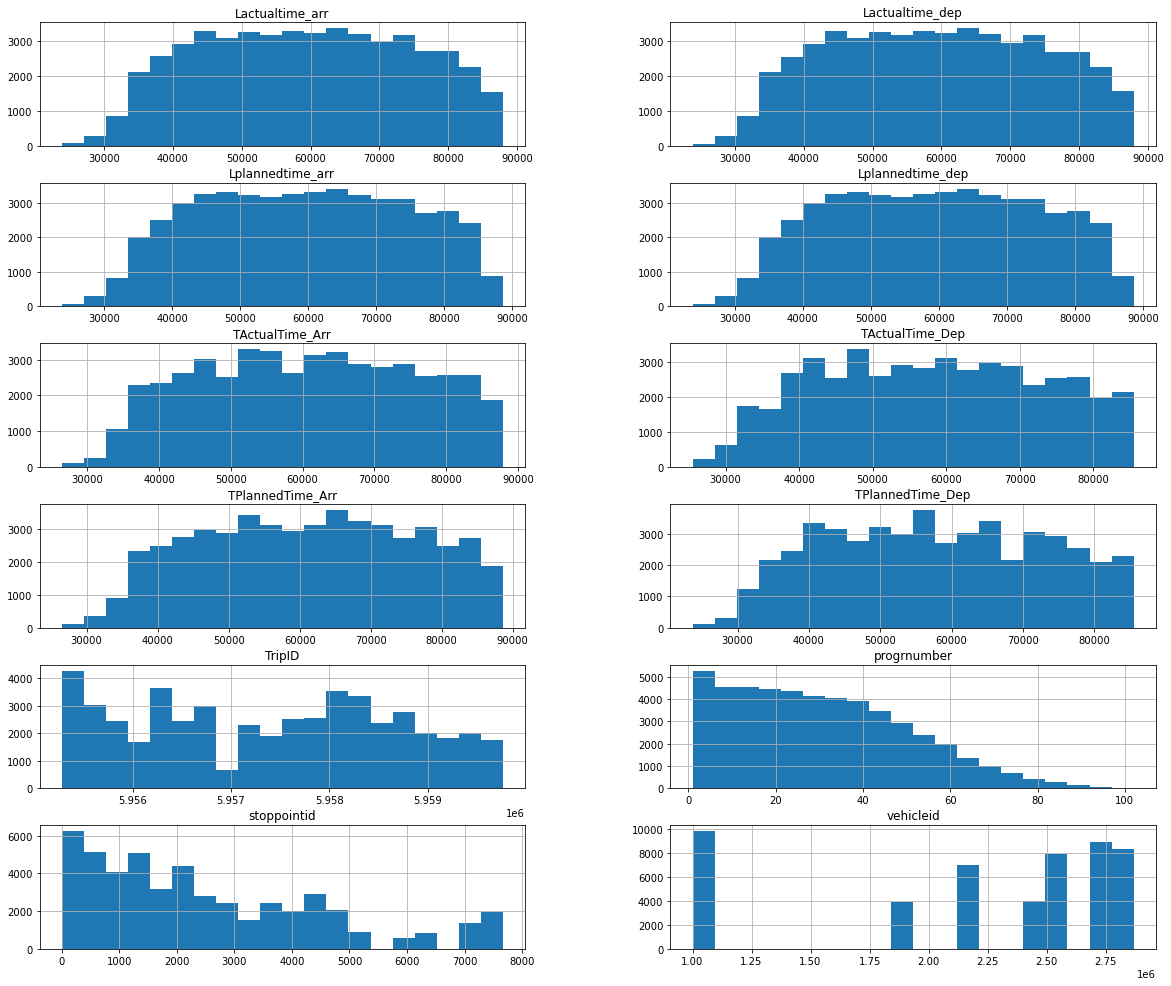

In [17]:
df[continuous_columns].hist(layout=(7, 2), figsize=(20,20), bins=20)
plt.show()

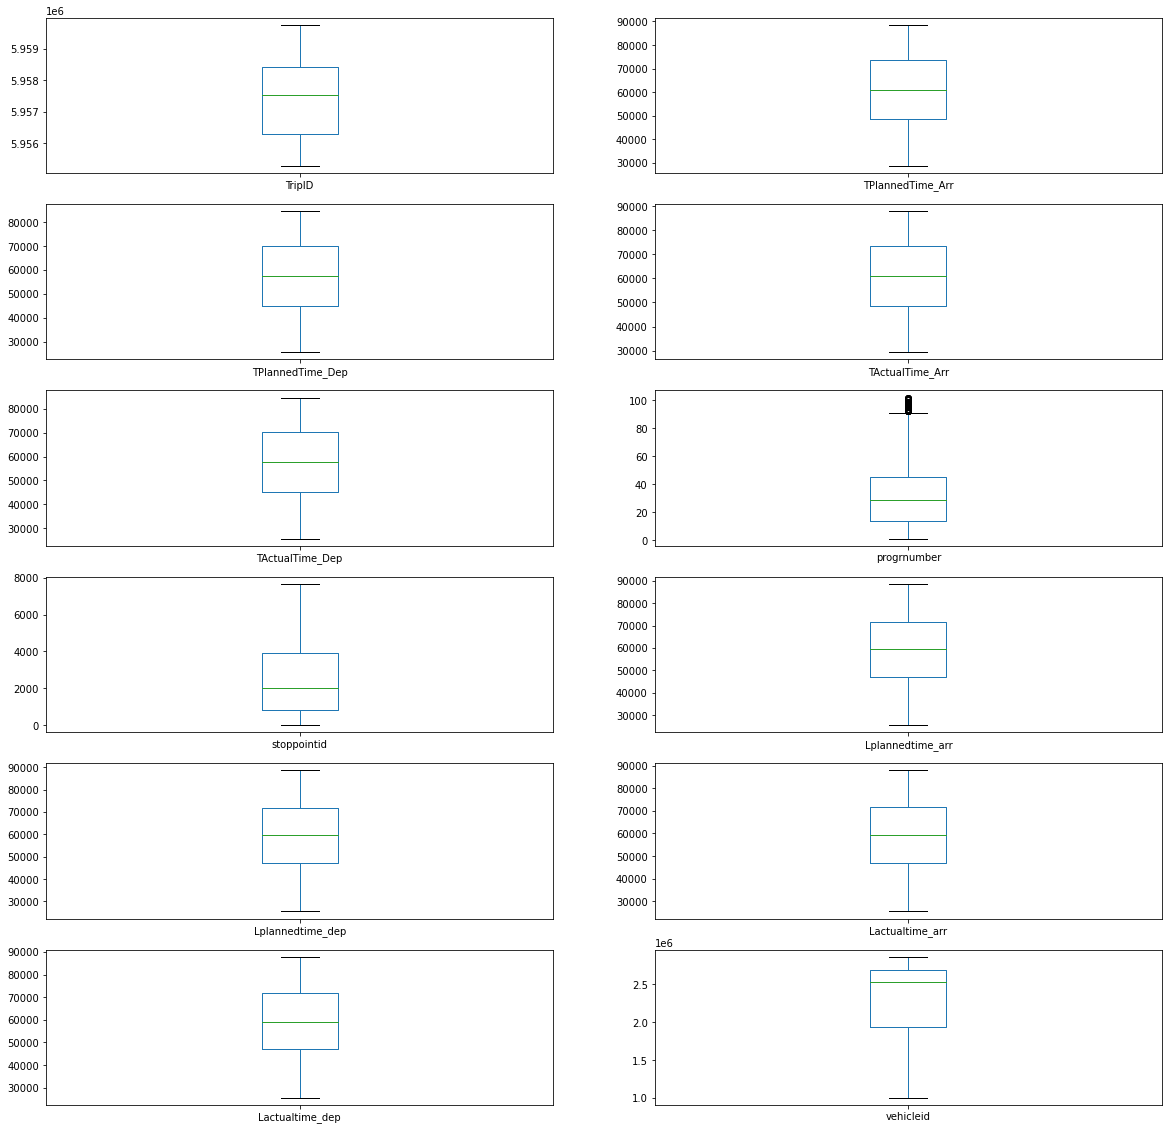

In [18]:
df[continuous_columns].dropna().astype('int64').plot(kind='box', subplots=True, figsize=(20,20), layout=(6,2), sharex=False, sharey=False)
plt.show()

In [19]:
corr = df[continuous_columns].corr()
corr

TripID  TPlannedTime_Arr  TPlannedTime_Dep  \
TripID            1.000000          0.009254          0.019786   
TPlannedTime_Arr  0.009254          1.000000          0.997494   
TPlannedTime_Dep  0.019786          0.997494          1.000000   
TActualTime_Arr   0.018960          0.999396          0.997417   
TActualTime_Dep   0.015967          0.997434          0.999975   
progrnumber      -0.099465         -0.001401         -0.026681   
stoppointid      -0.039139          0.011949          0.013204   
Lplannedtime_arr  0.015058          0.996698          0.996713   
Lplannedtime_dep  0.015058          0.996698          0.996713   
Lactualtime_arr   0.014932          0.996949          0.997273   
Lactualtime_dep   0.014961          0.996950          0.997268   
vehicleid         0.057874          0.124780          0.109126   

                  TActualTime_Arr  TActualTime_Dep  progrnumber  stoppointid  \
TripID                   0.018960         0.015967    -0.099465    -0.039139   
TPlannedTime_Arr         0.999396         0.997434    -0.001401     0.011949   
TPlannedTime_Dep         0.997417         0.999975    -0.026681     0.013204   
TActualTime_Arr          1.000000         0.997398     0.003680     0.014667   
TActualTime_Dep          0.997398         1.000000    -0.024384     0.016074   
progrnumber              0.003680        -0.024384     1.000000     0.000851   
stoppointid              0.014667         0.016074     0.000851     1.000000   
Lplannedtime_arr         0.996248         0.996621     0.050412     0.013357   
Lplannedtime_dep         0.996248         0.996621     0.050412     0.013357   
Lactualtime_arr          0.996875         0.997233     0.042855     0.014168   
Lactualtime_dep          0.996881         0.997228     0.042867     0.014124   
vehicleid                0.117921         0.116108     0.078196    -0.038844   

                  Lplannedtime_arr  Lplannedtime_dep  Lactualtime_arr  \
TripID                    0.015058          0.015058         0.014932   
TPlannedTime_Arr          0.996698          0.996698         0.996949   
TPlannedTime_Dep          0.996713          0.996713         0.997273   
TActualTime_Arr           0.996248          0.996248         0.996875   
TActualTime_Dep           0.996621          0.996621         0.997233   
progrnumber               0.050412          0.050412         0.042855   
stoppointid               0.013357          0.013357         0.014168   
Lplannedtime_arr          1.000000          1.000000         0.999804   
Lplannedtime_dep          1.000000          1.000000         0.999804   
Lactualtime_arr           0.999804          0.999804         1.000000   
Lactualtime_dep           0.999802          0.999802         0.999998   
vehicleid                 0.117116          0.117116         0.115522   

                  Lactualtime_dep  vehicleid  
TripID                   0.014961   0.057874  
TPlannedTime_Arr         0.996950   0.124780  
TPlannedTime_Dep         0.997268   0.109126  
TActualTime_Arr          0.996881   0.117921  
TActualTime_Dep          0.997228   0.116108  
progrnumber              0.042867   0.078196  
stoppointid              0.014124  -0.038844  
Lplannedtime_arr         0.999802   0.117116  
Lplannedtime_dep         0.999802   0.117116  
Lactualtime_arr          0.999998   0.115522  
Lactualtime_dep          1.000000   0.115579  
vehicleid                0.115579   1.000000

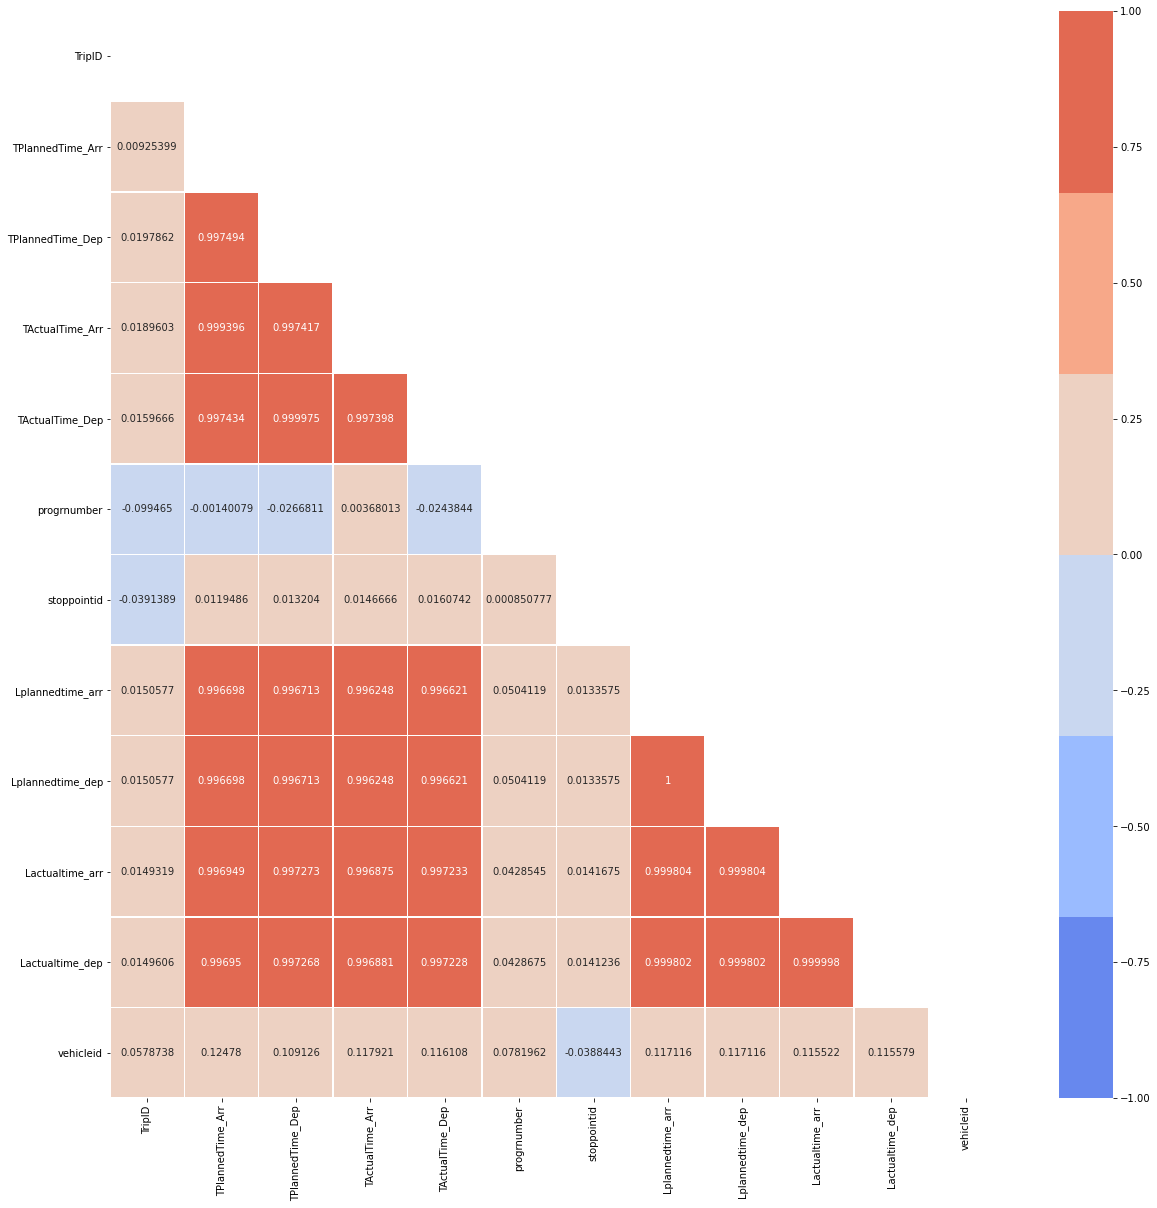

In [20]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (20,20))
color = sns.color_palette("coolwarm")
sns.heatmap(corr, cmap=color, annot=True, fmt='g', vmax=1, vmin=-1,linewidths=.5, mask=mask)

C:\Users\frank\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


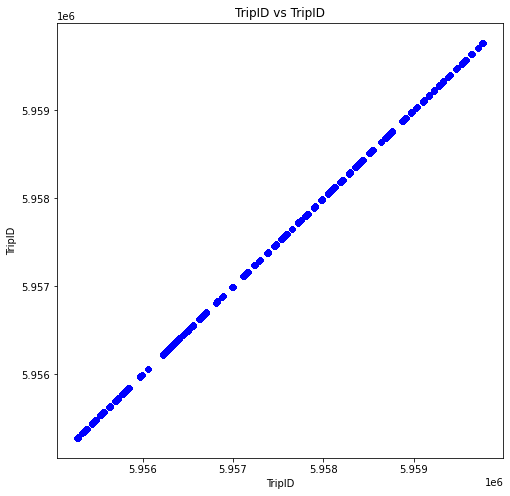

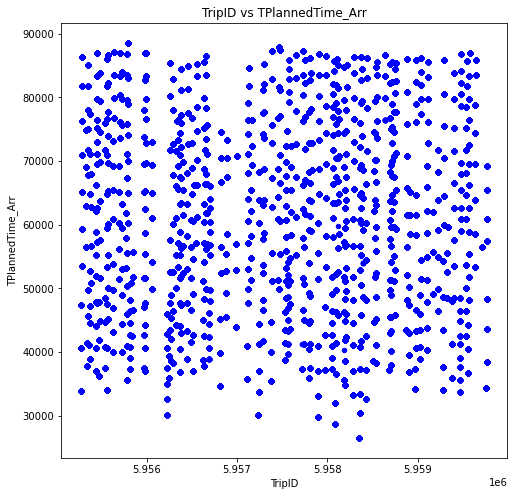

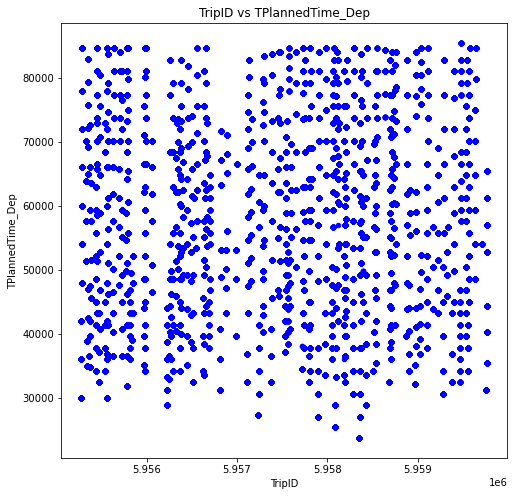

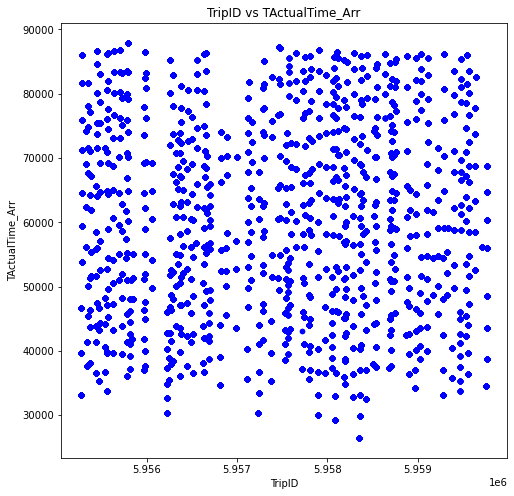

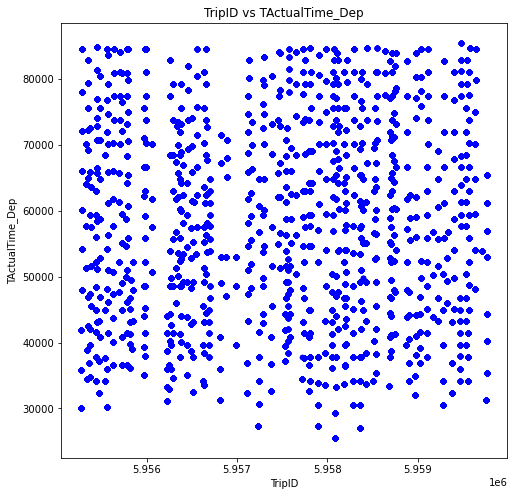

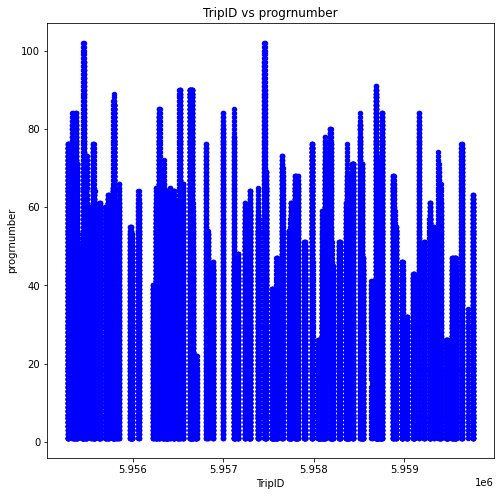

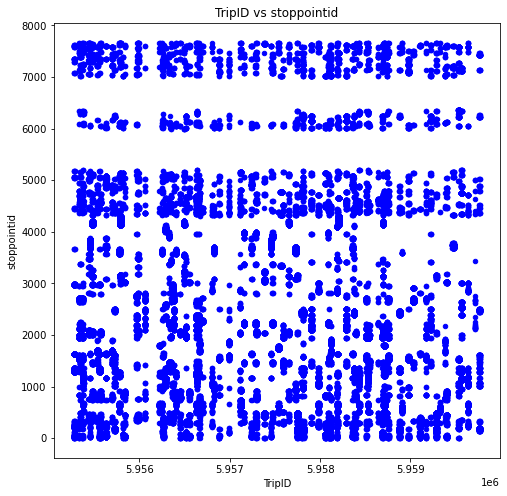

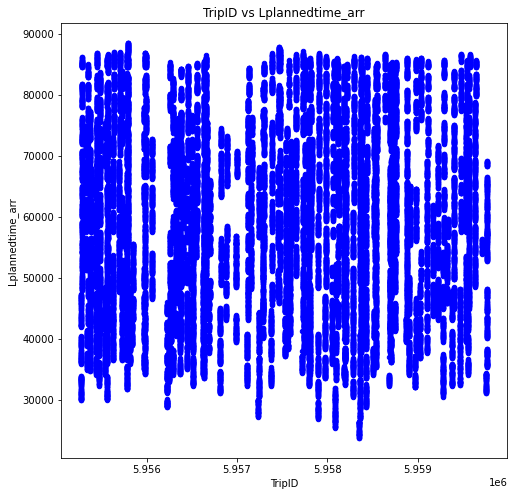

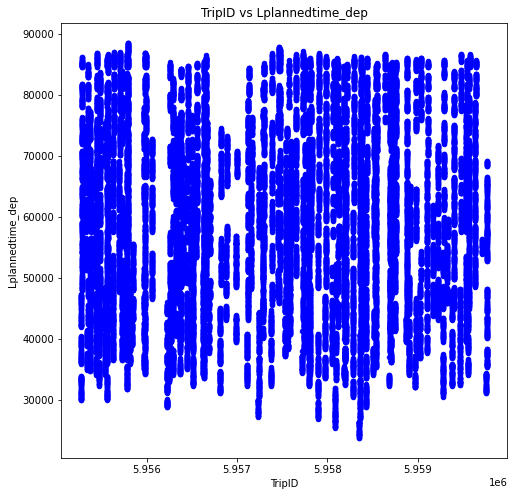

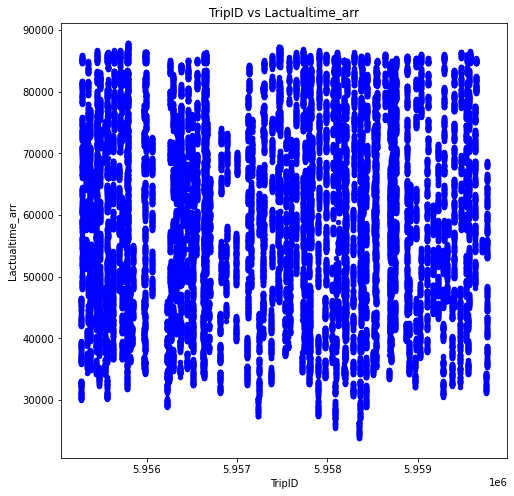

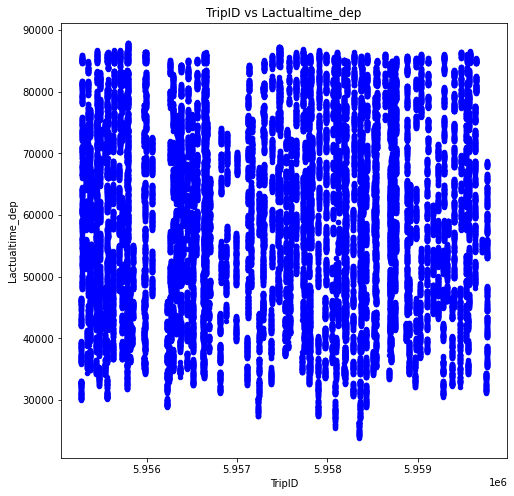

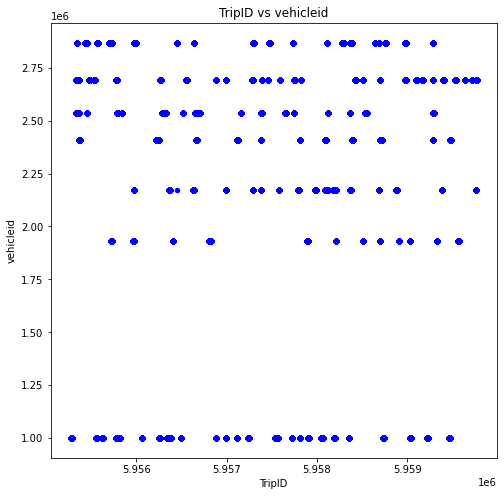

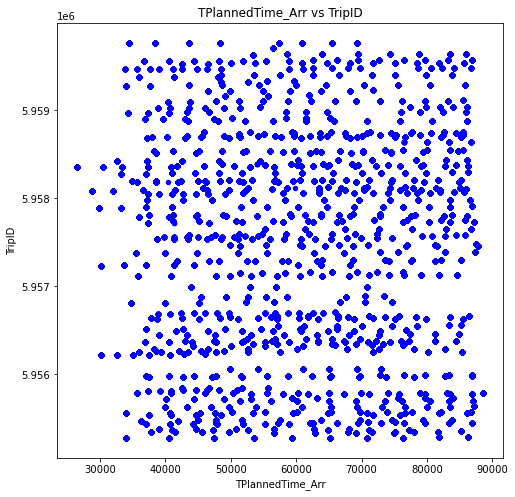

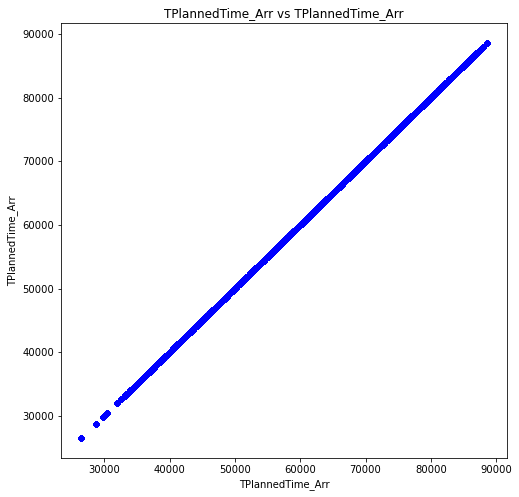

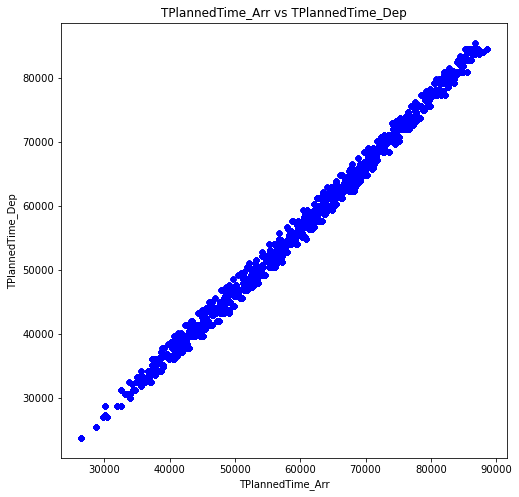

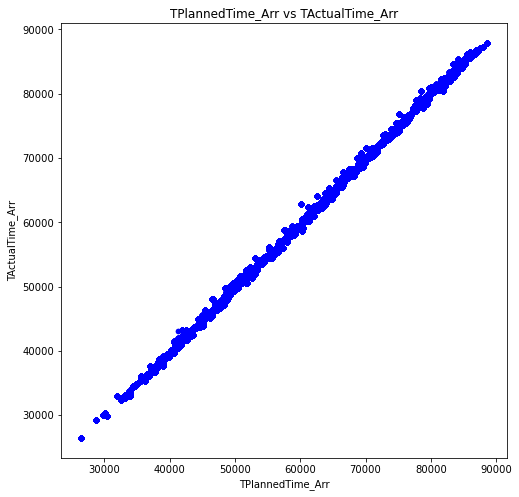

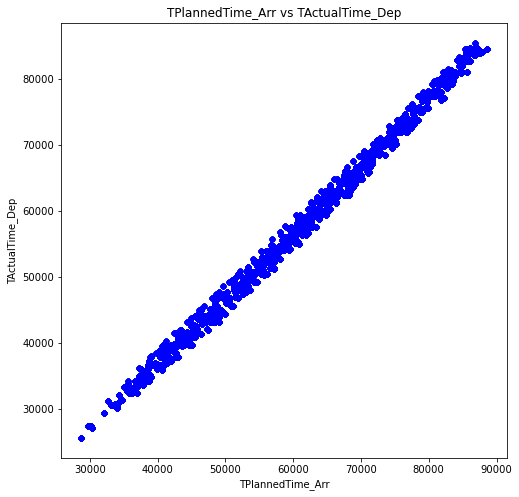

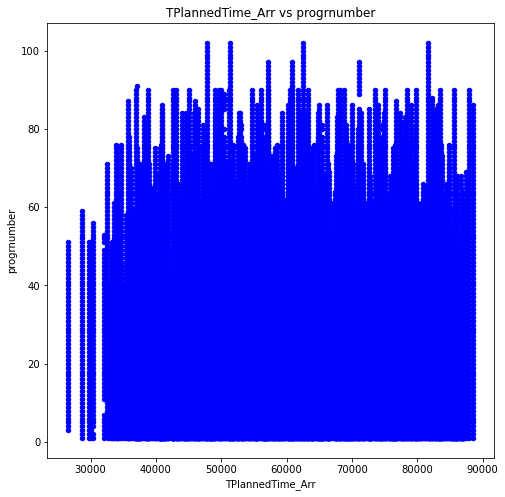

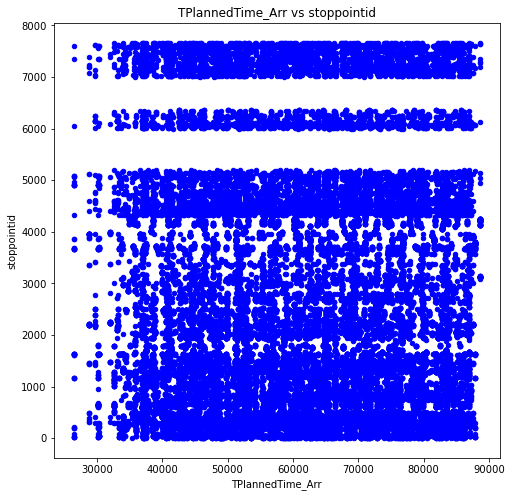

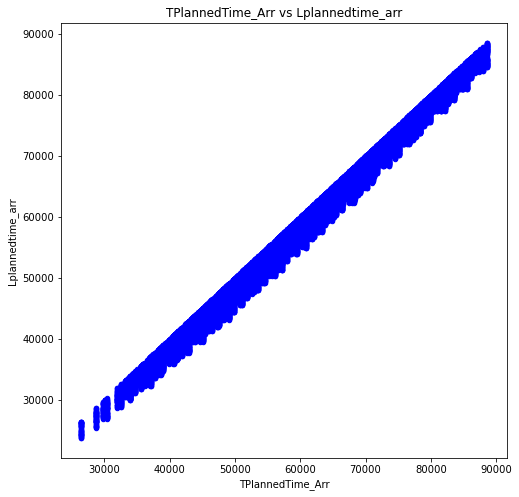

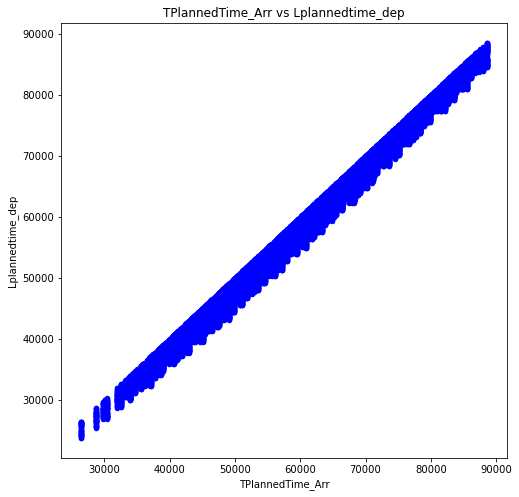

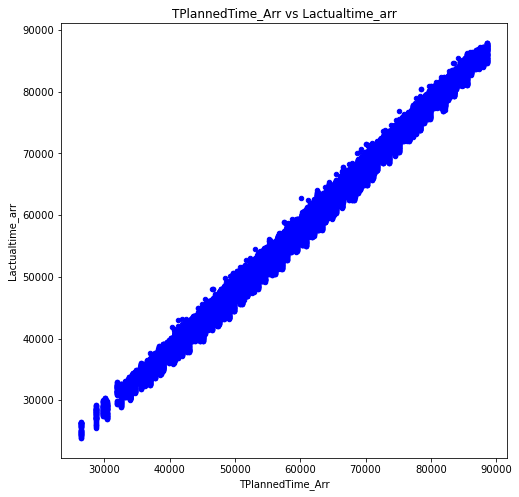

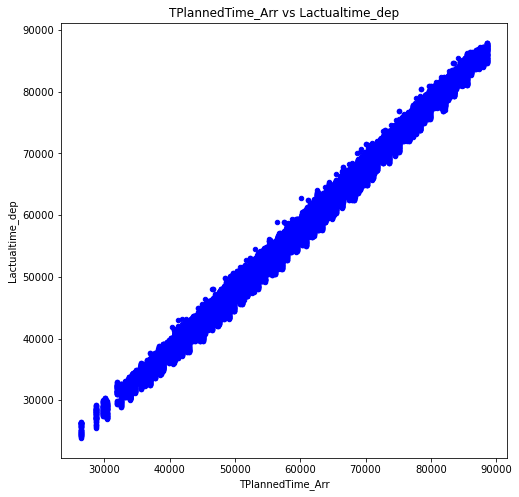

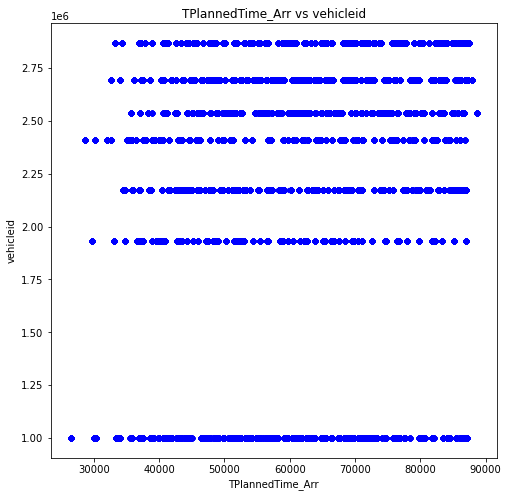

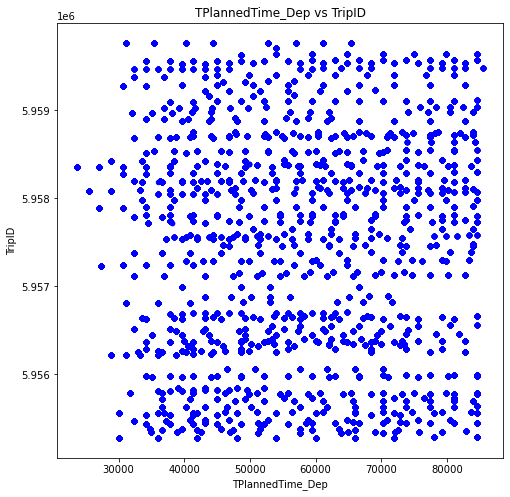

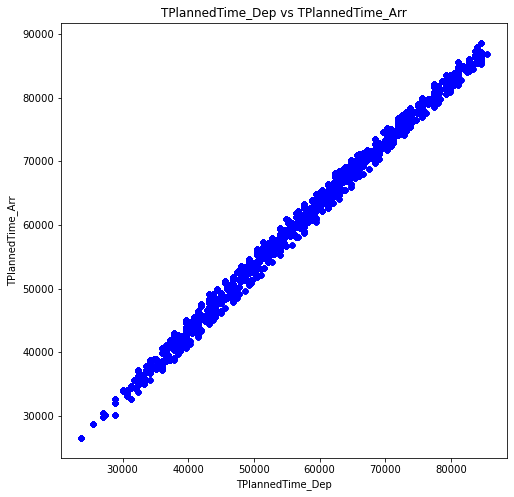

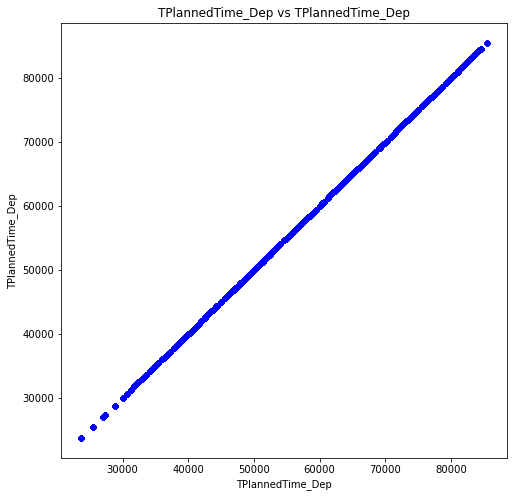

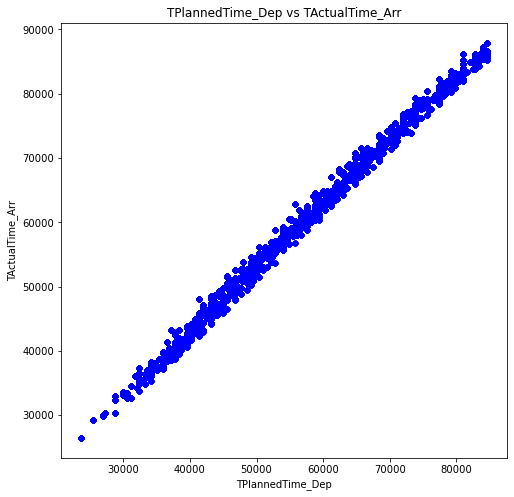

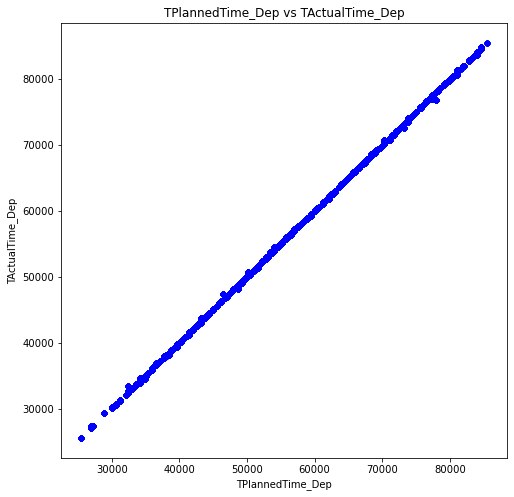

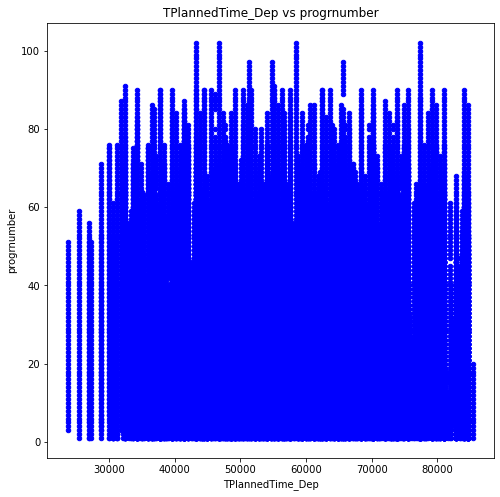

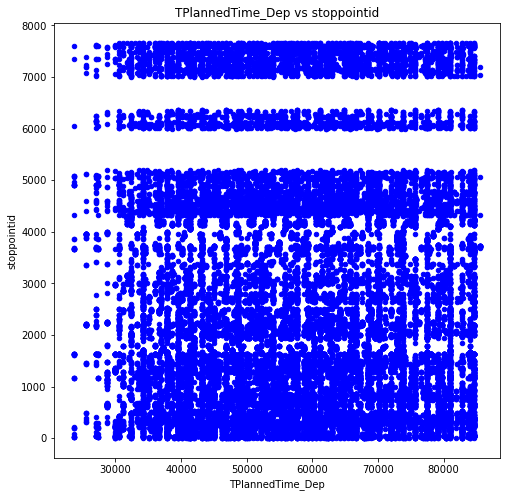

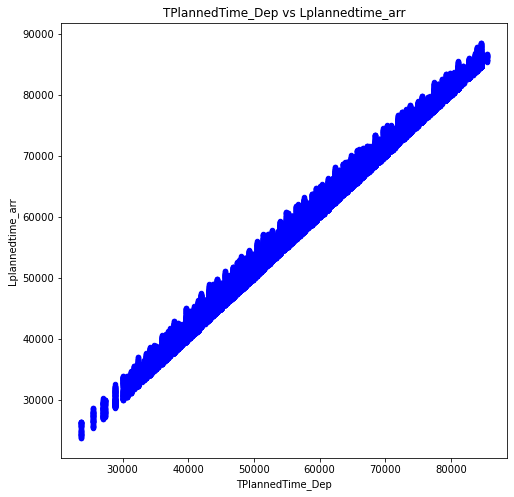

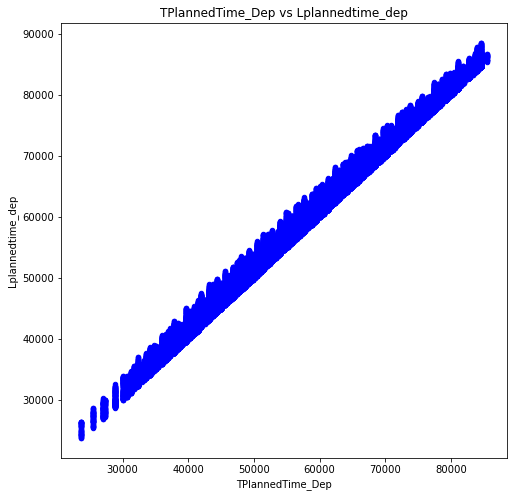

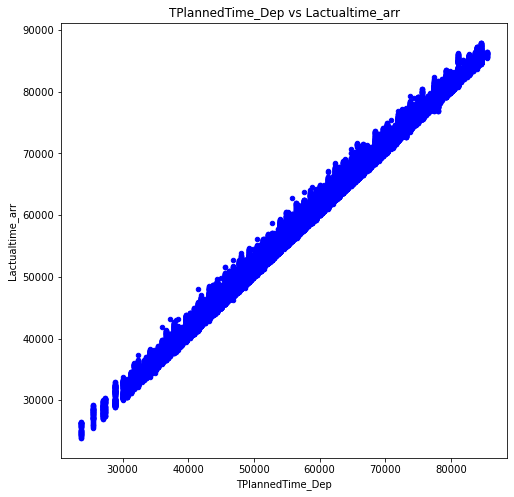

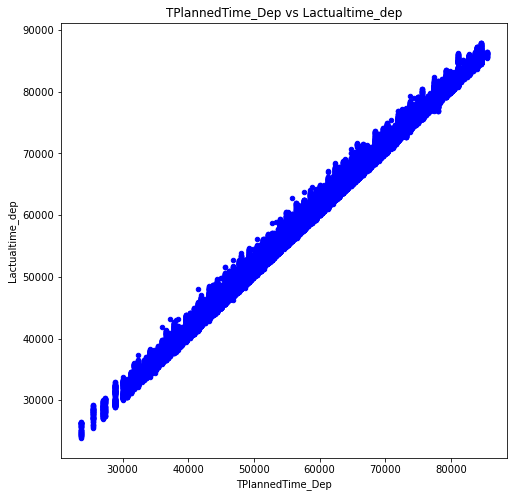

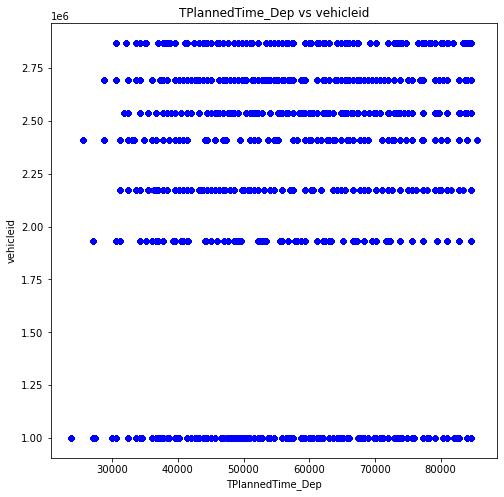

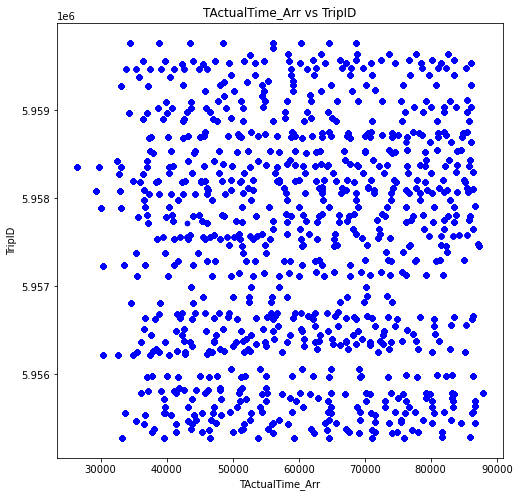

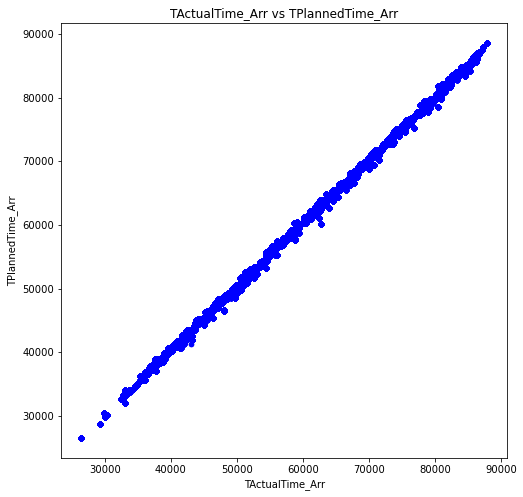

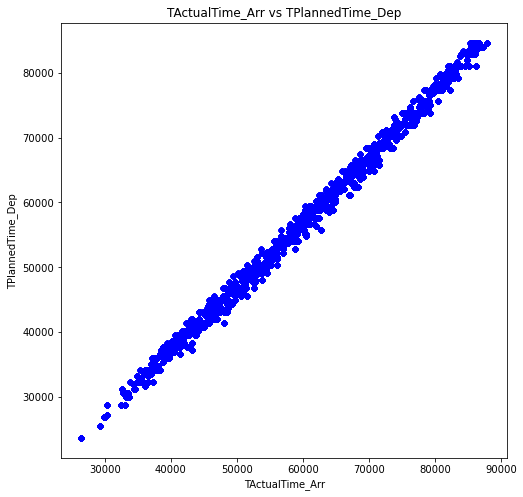

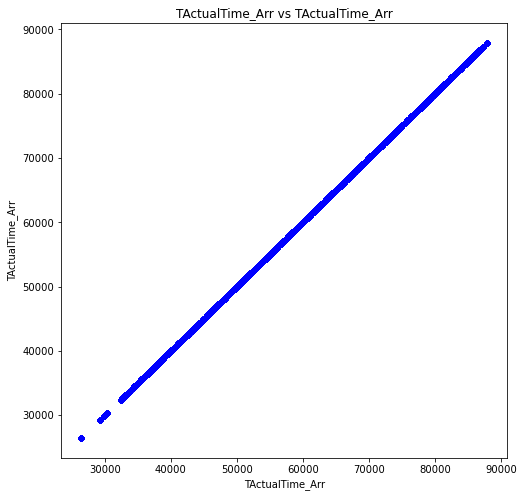

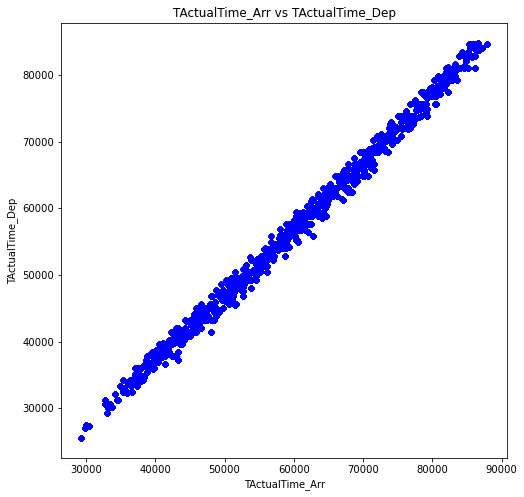

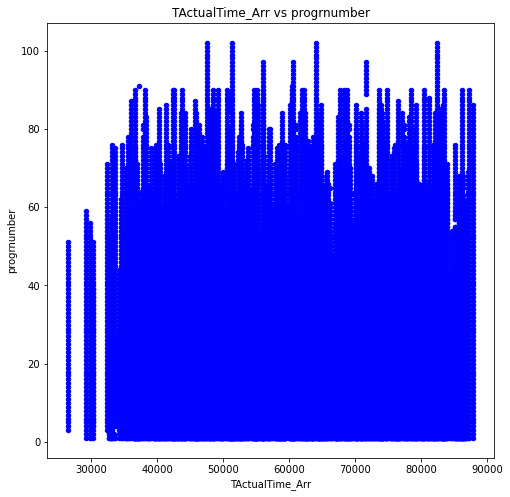

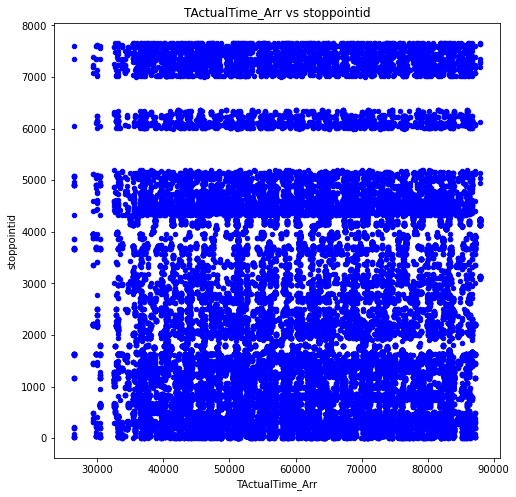

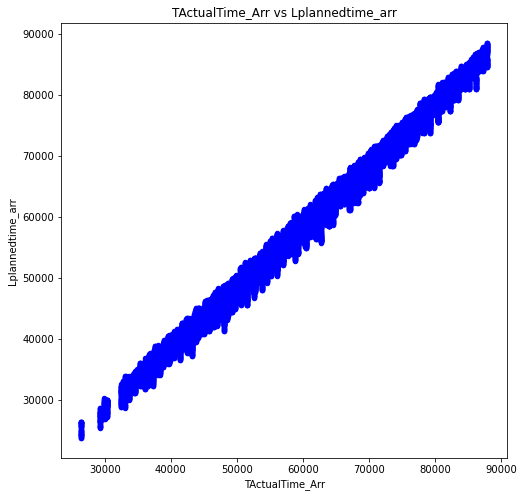

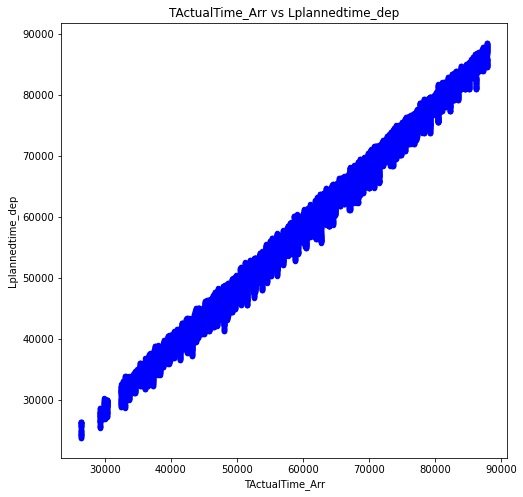

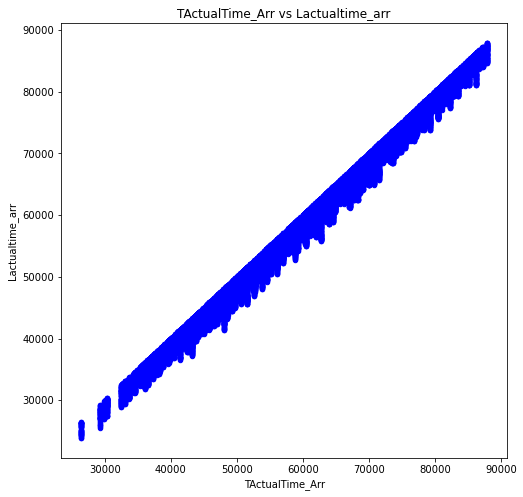

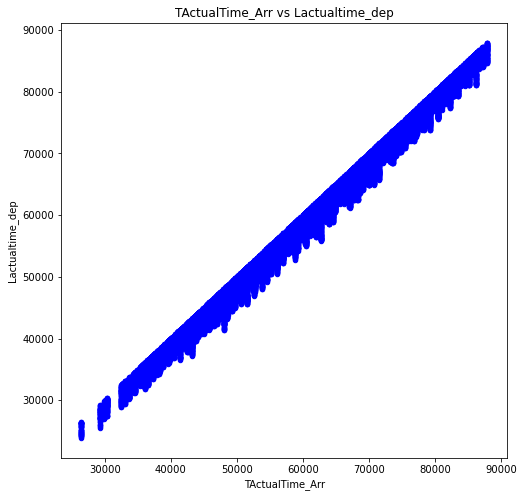

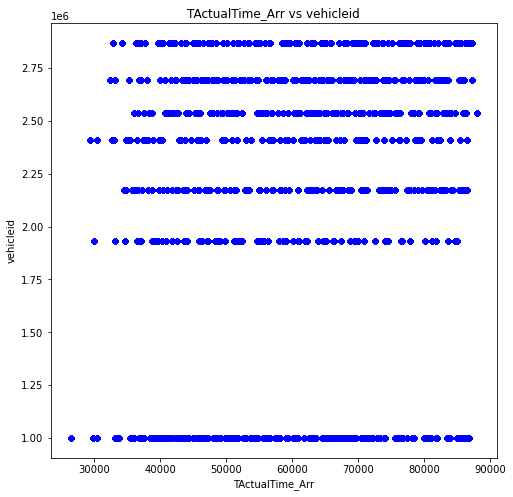

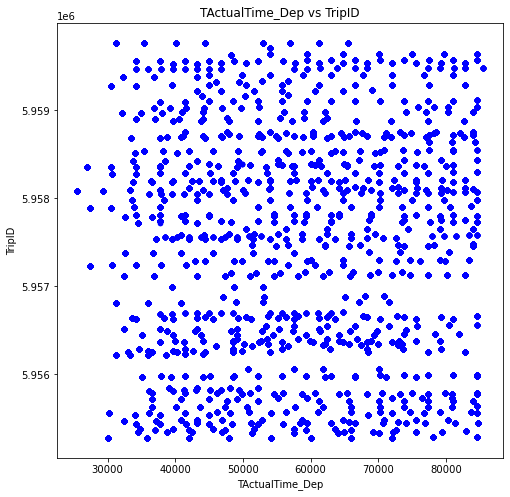

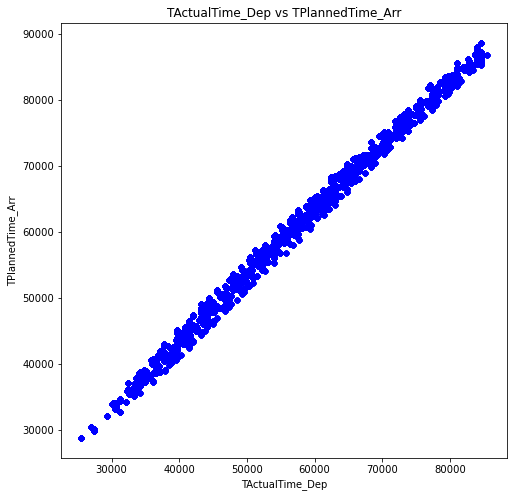

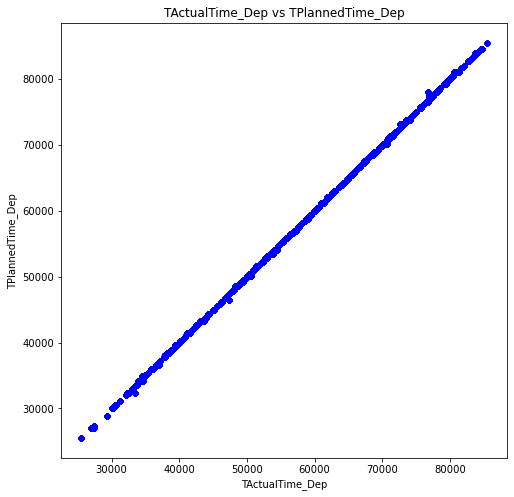

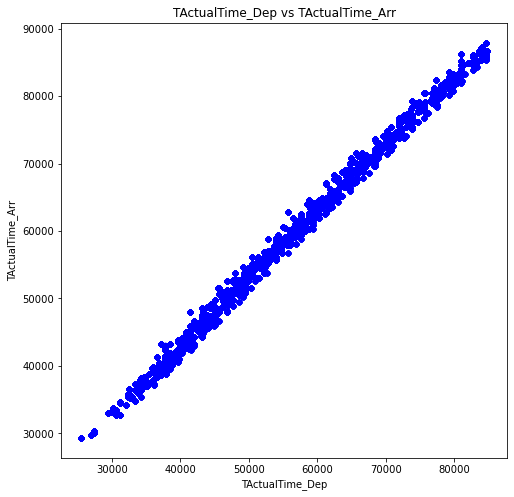

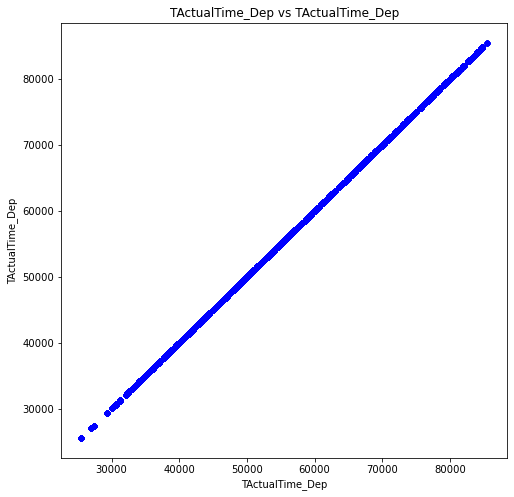

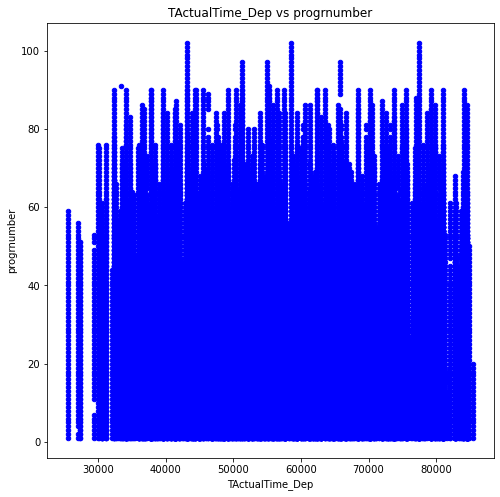

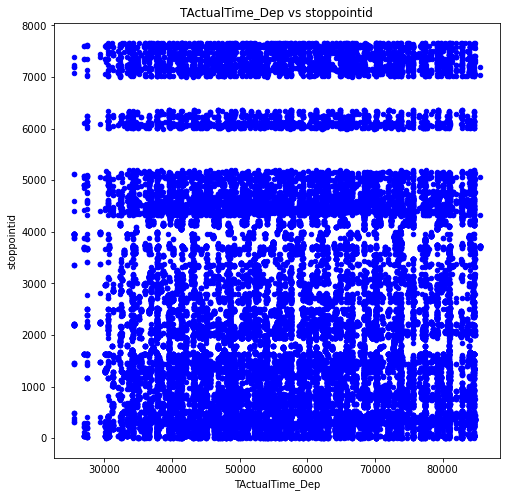

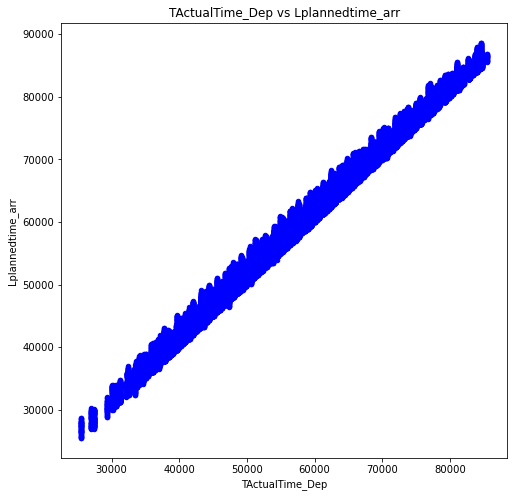

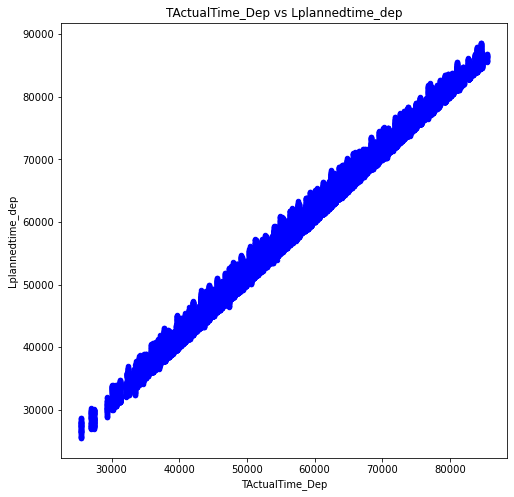

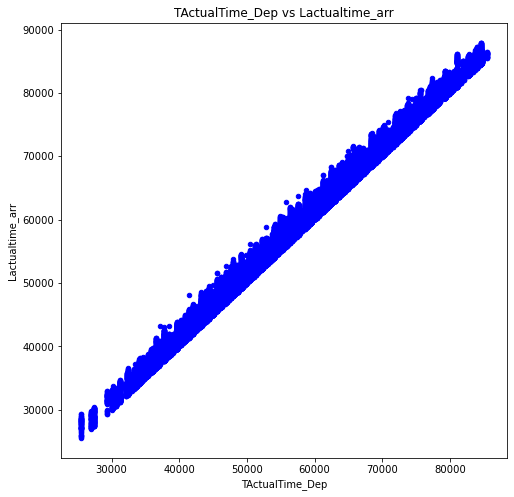

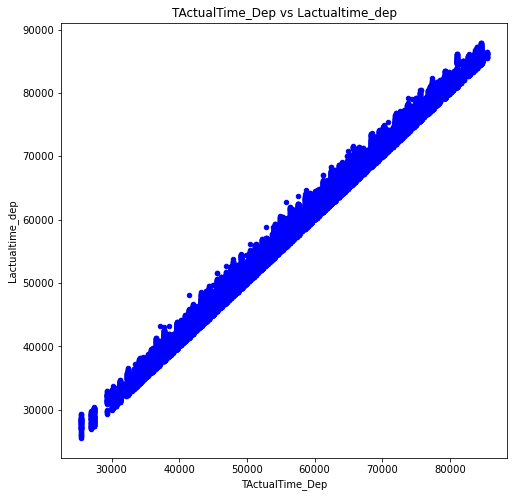

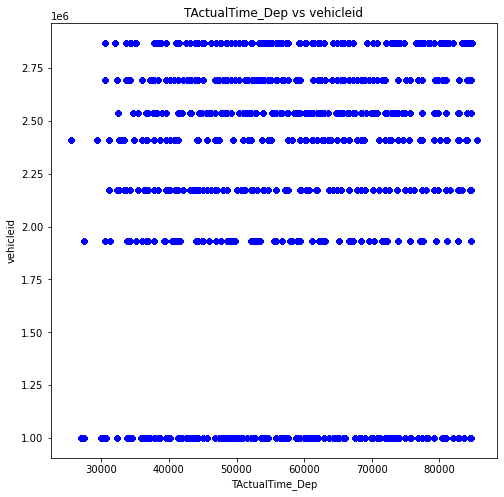

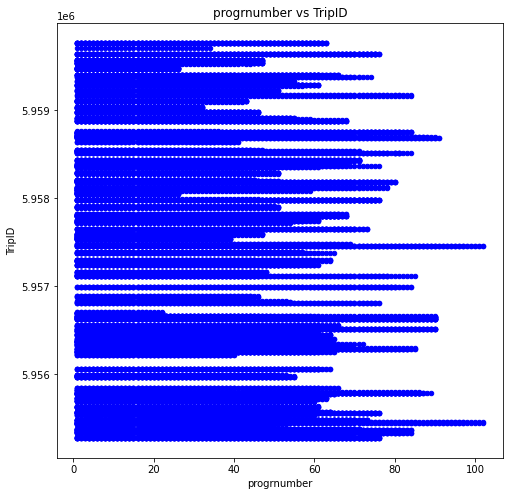

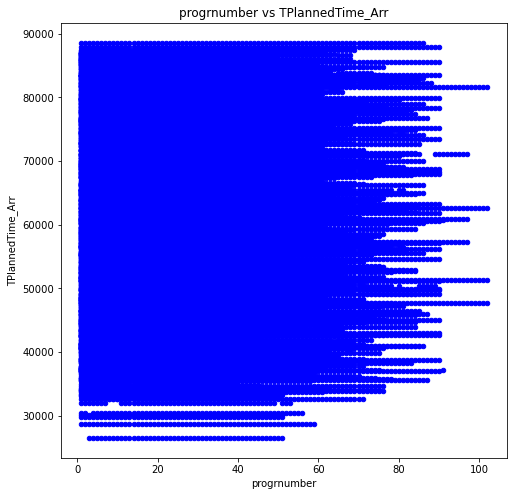

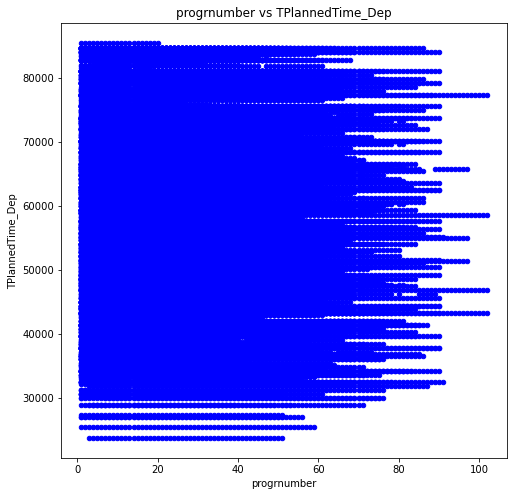

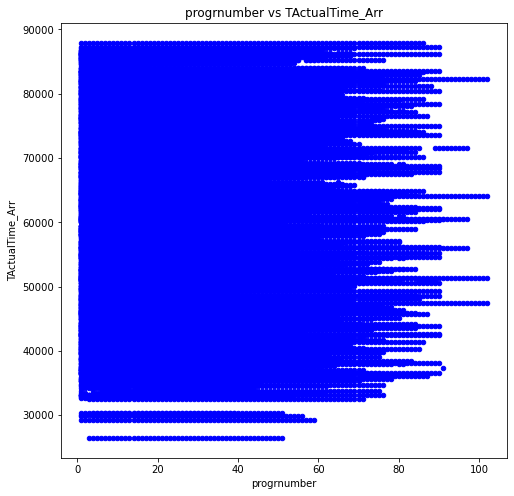

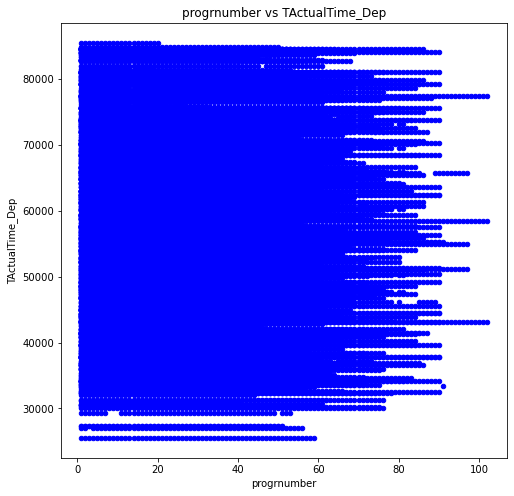

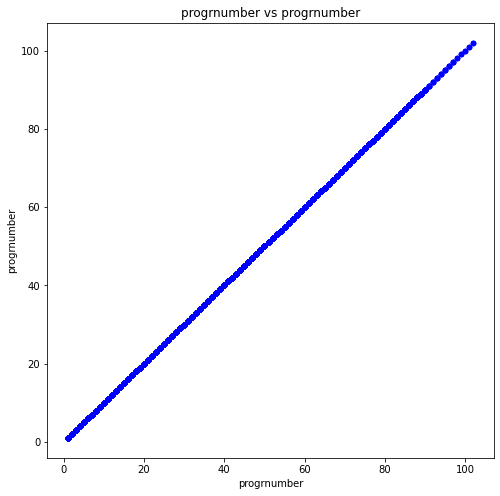

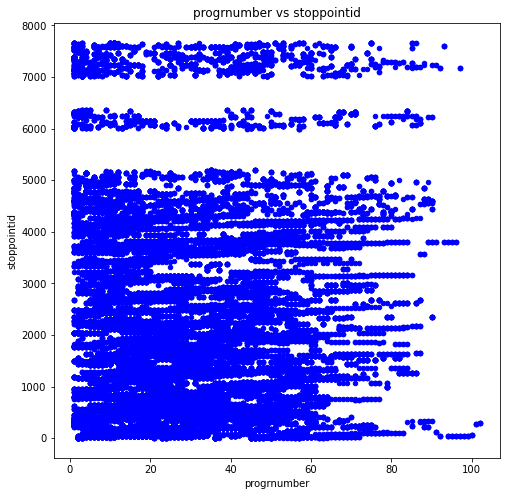

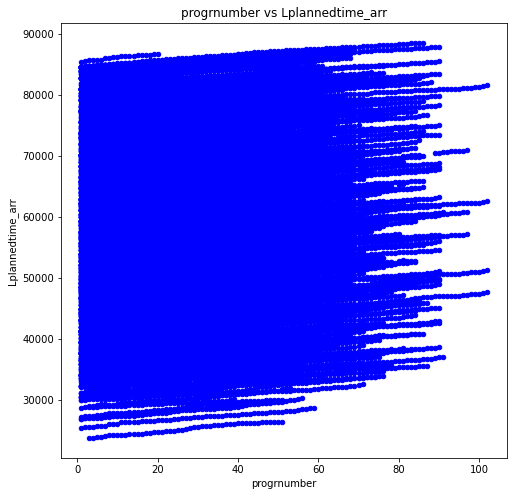

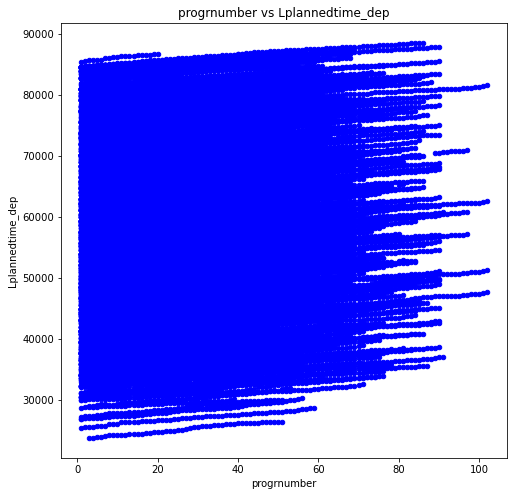

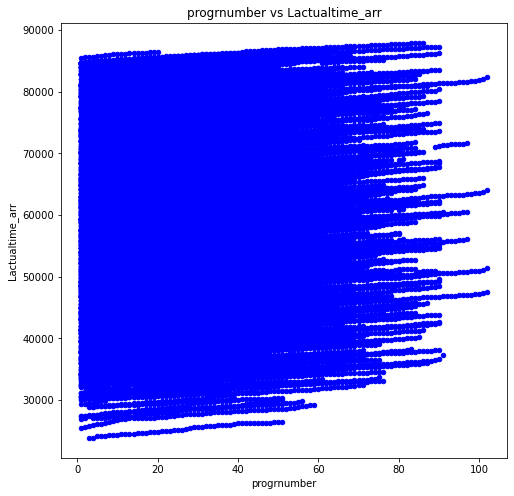

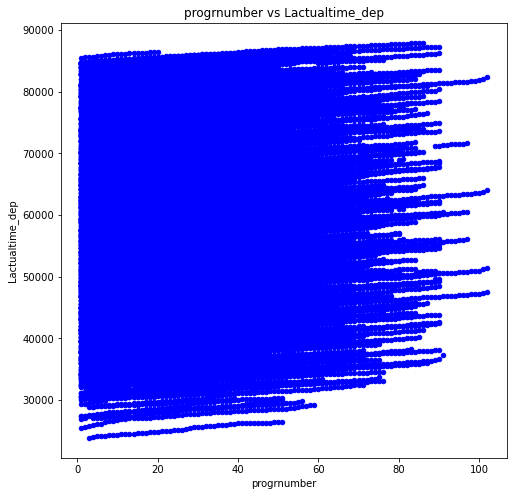

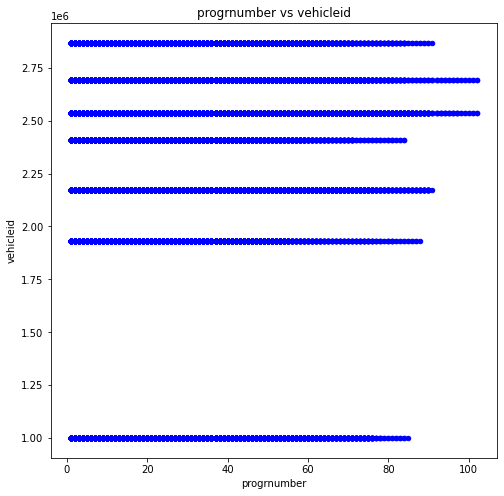

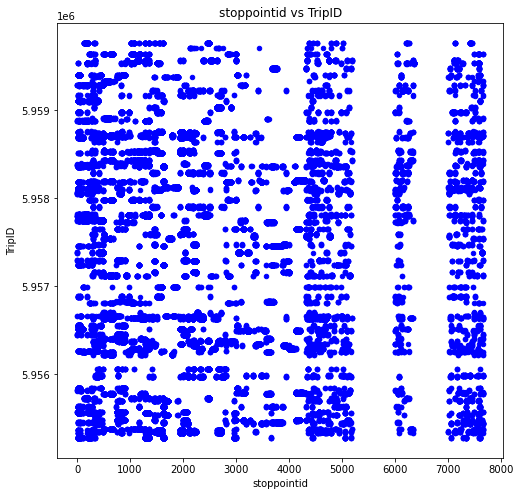

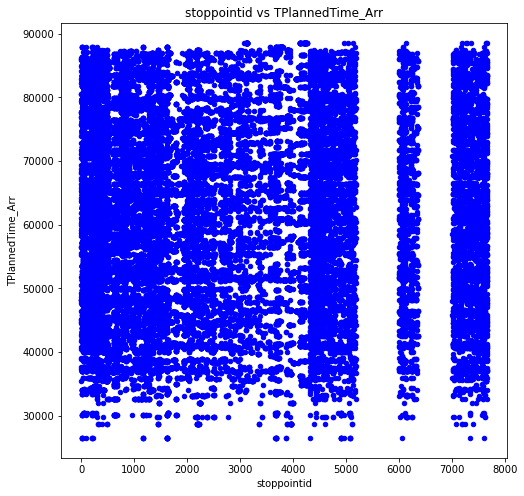

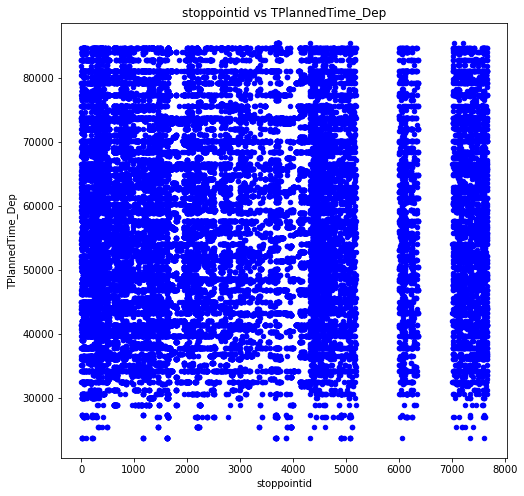

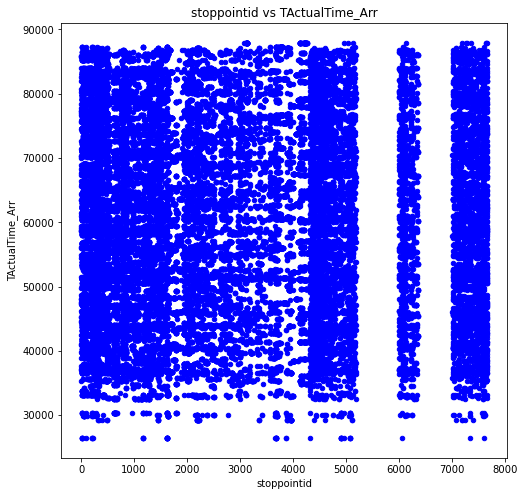

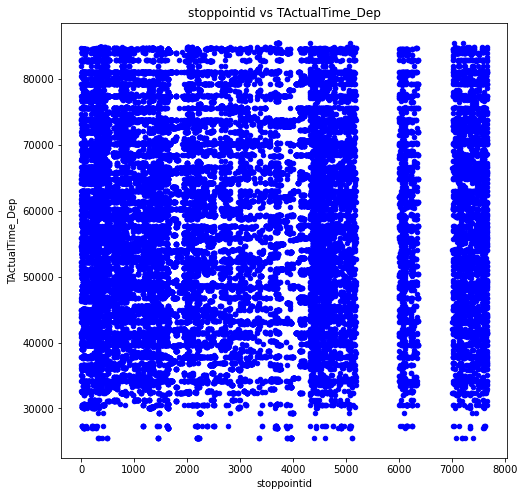

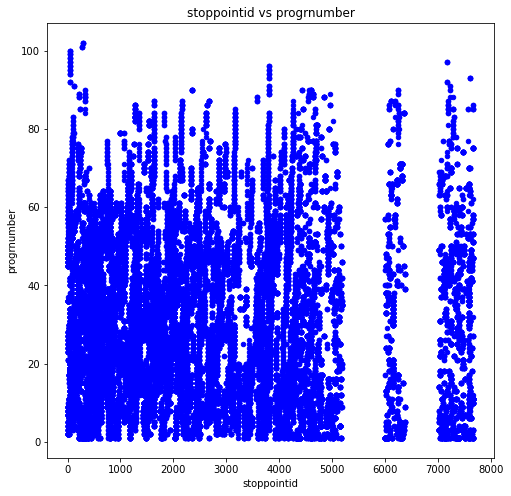

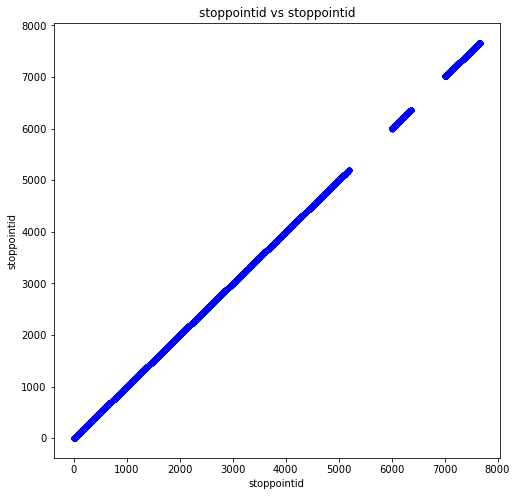

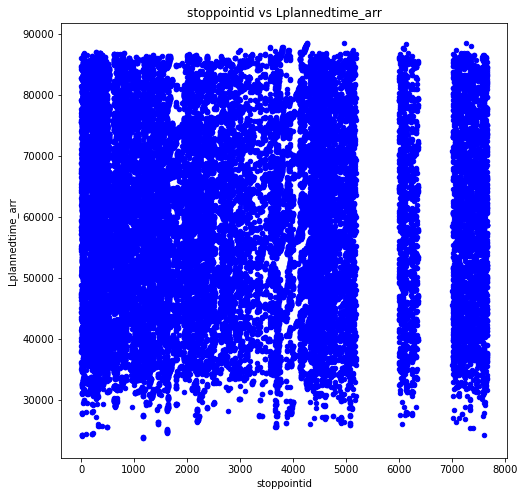

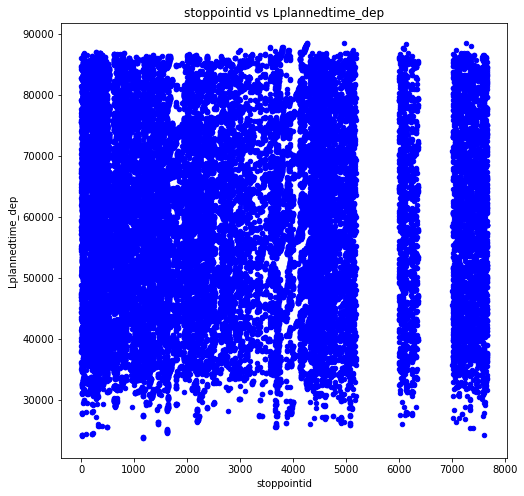

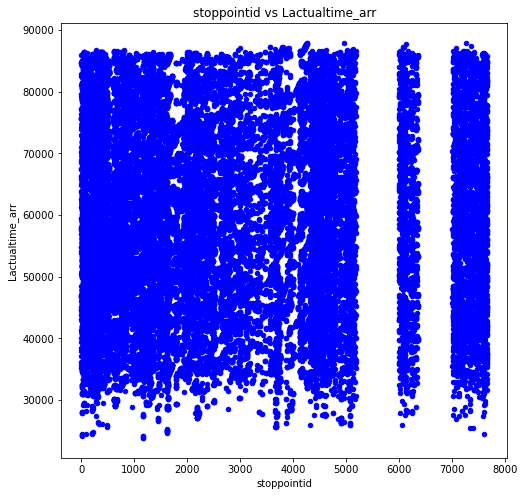

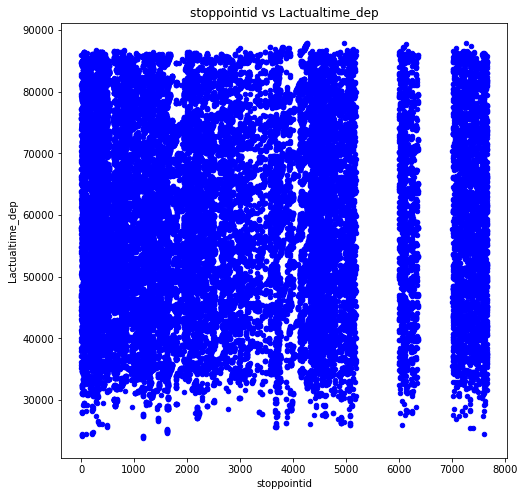

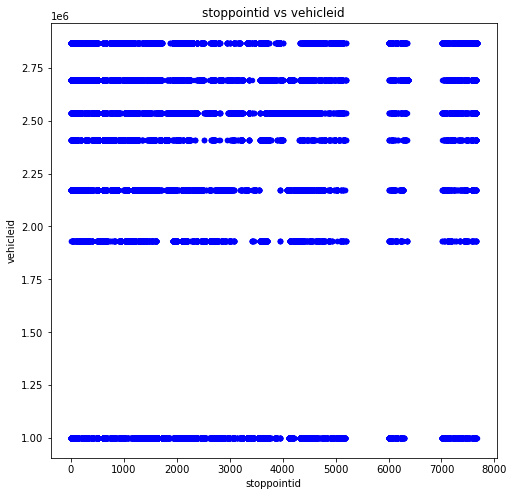

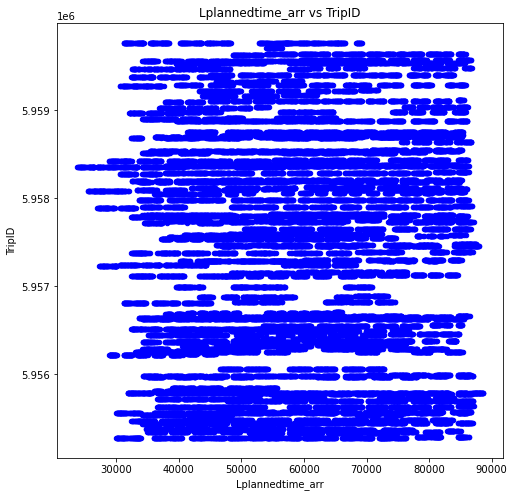

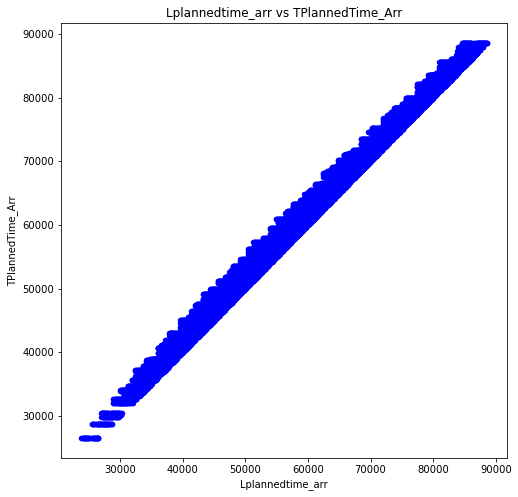

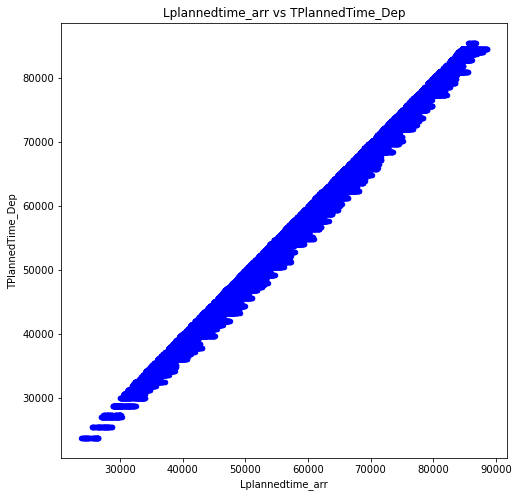

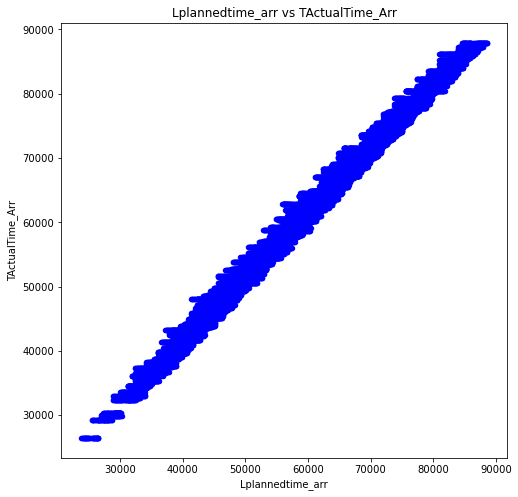

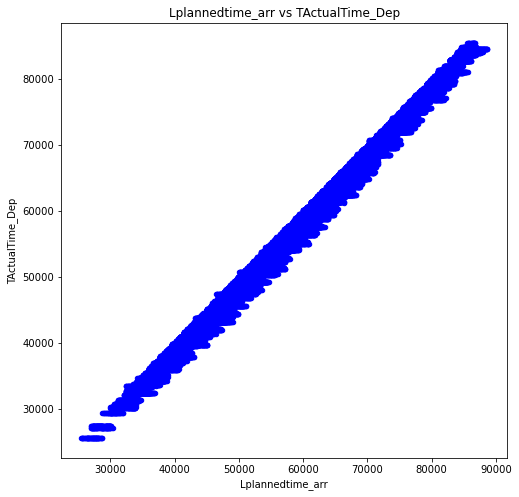

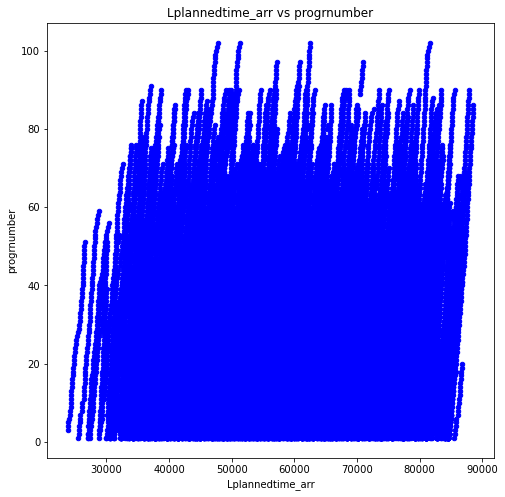

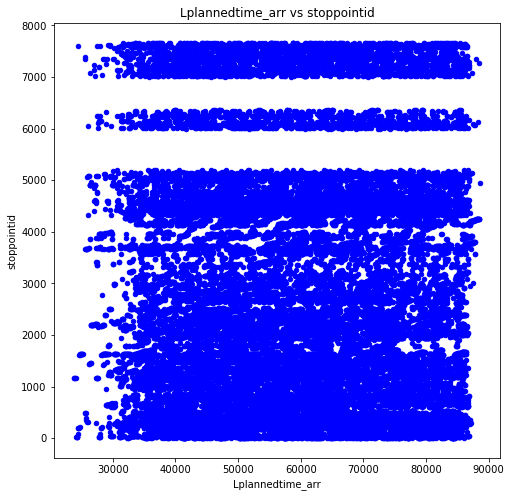

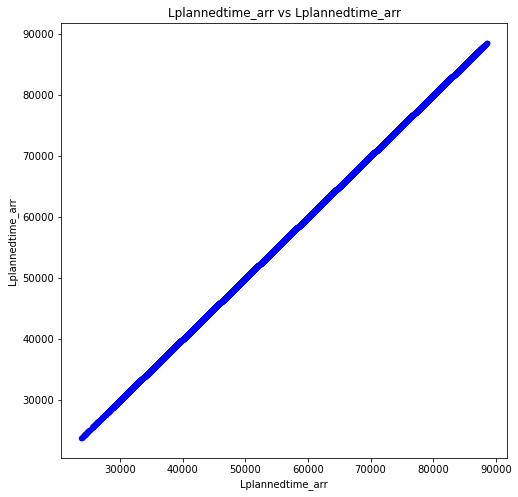

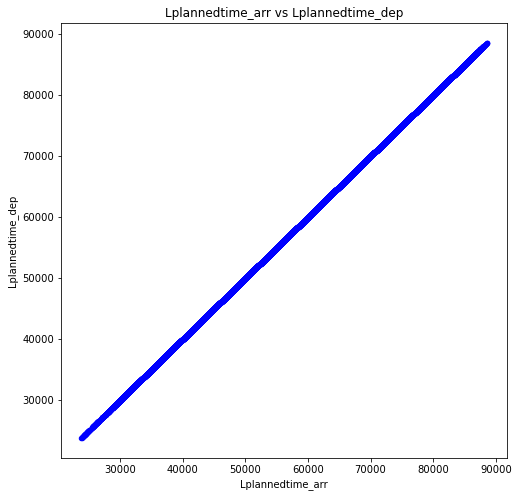

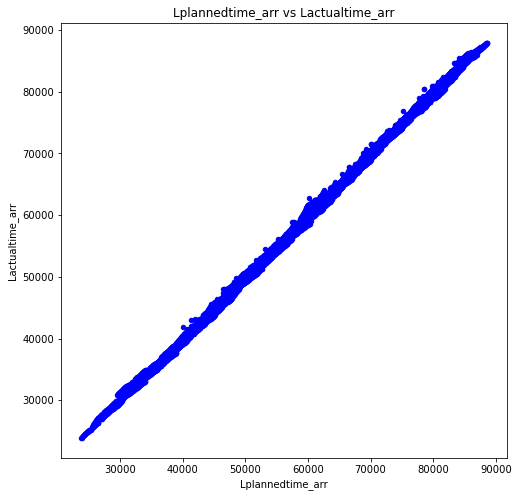

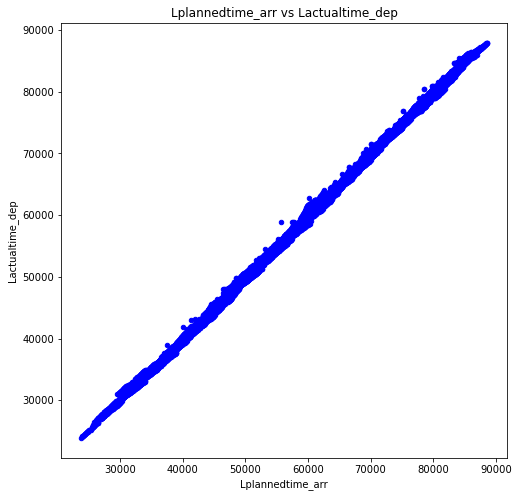

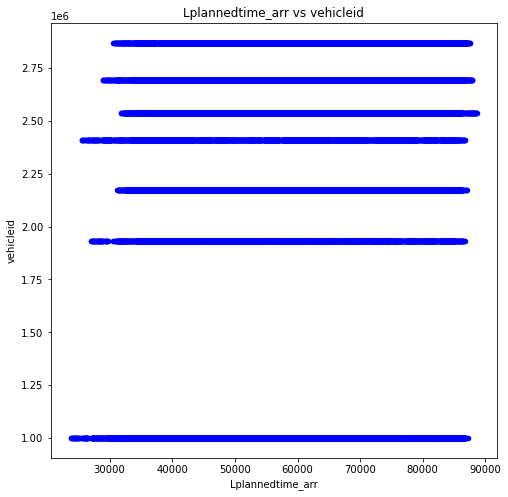

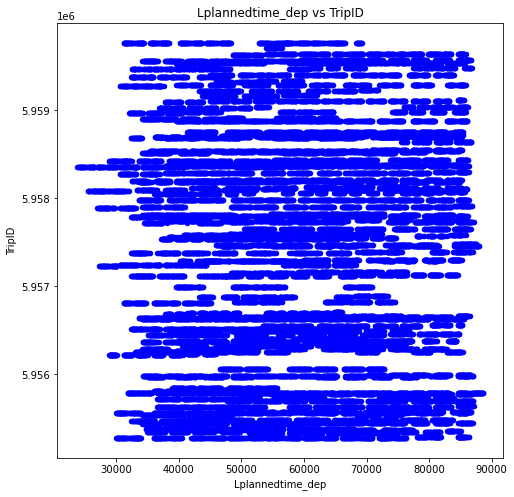

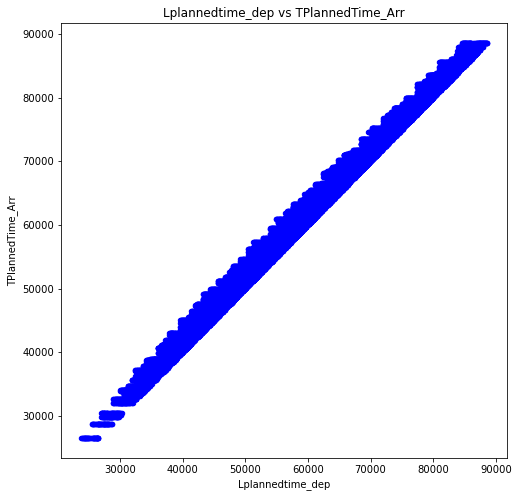

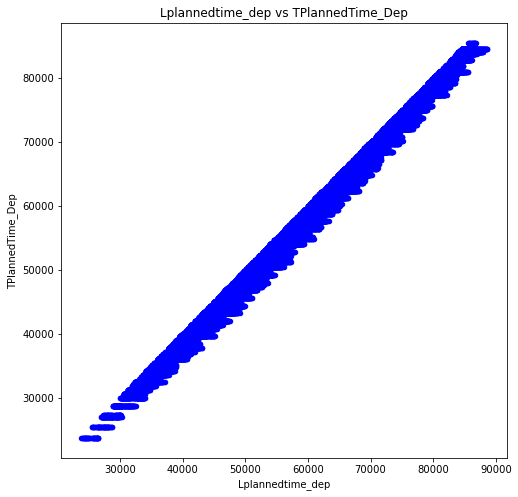

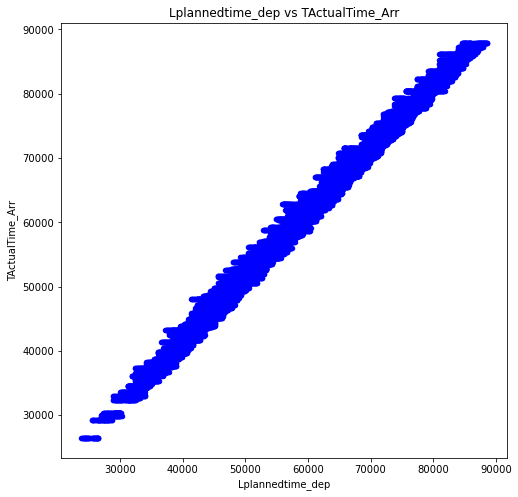

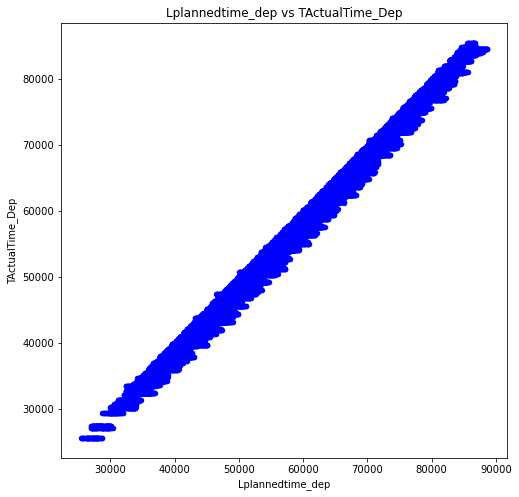

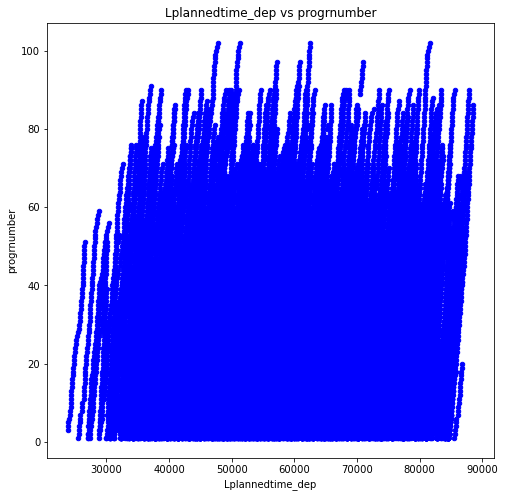

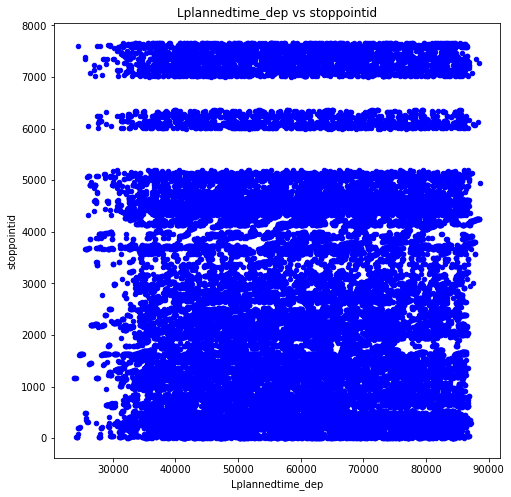

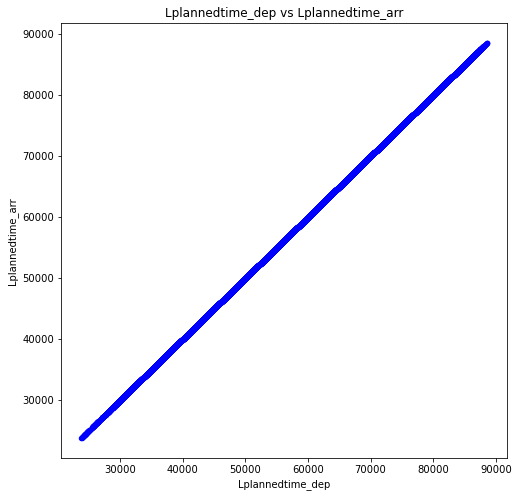

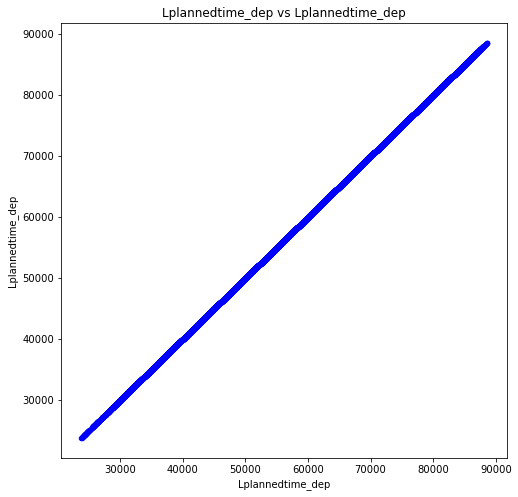

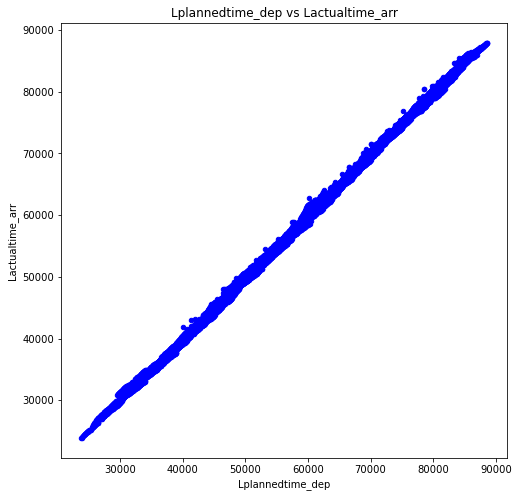

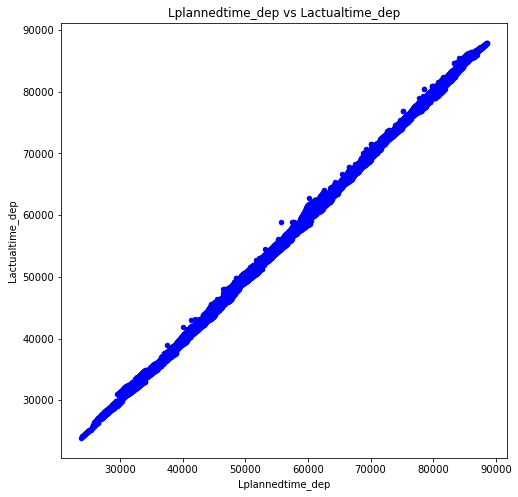

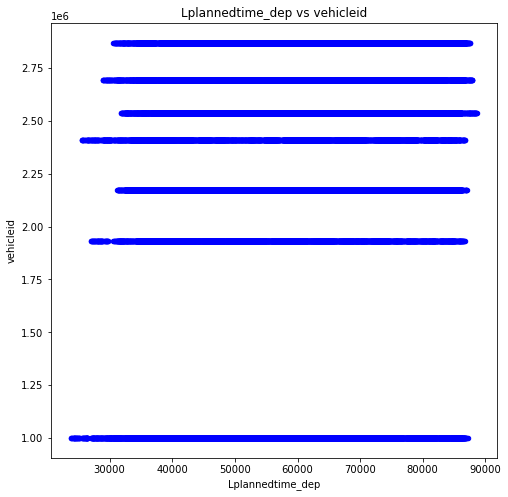

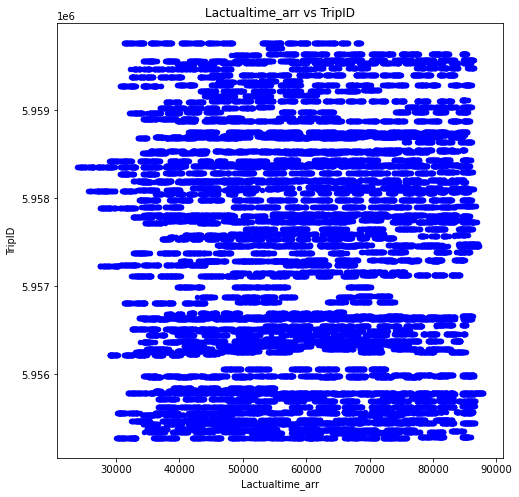

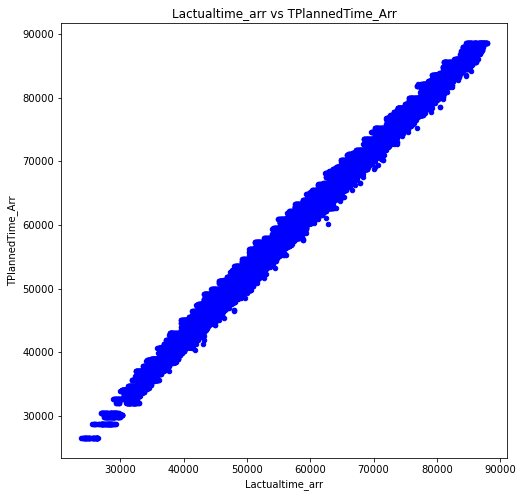

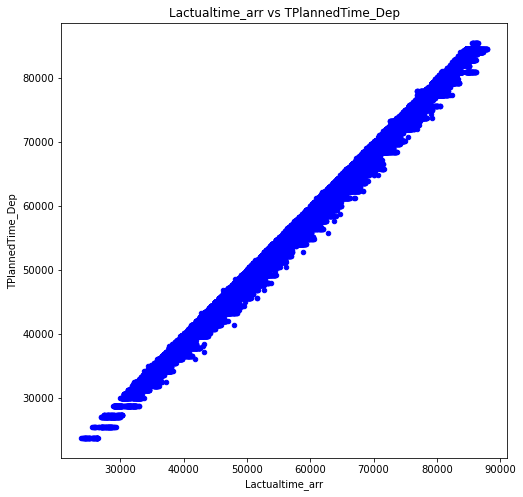

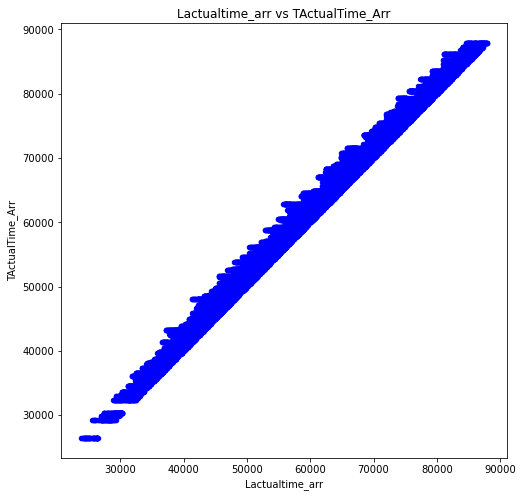

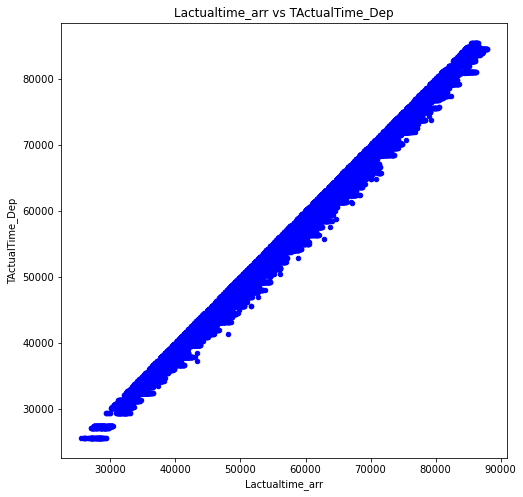

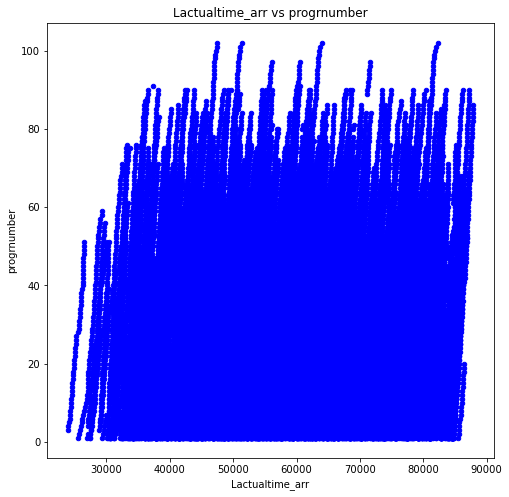

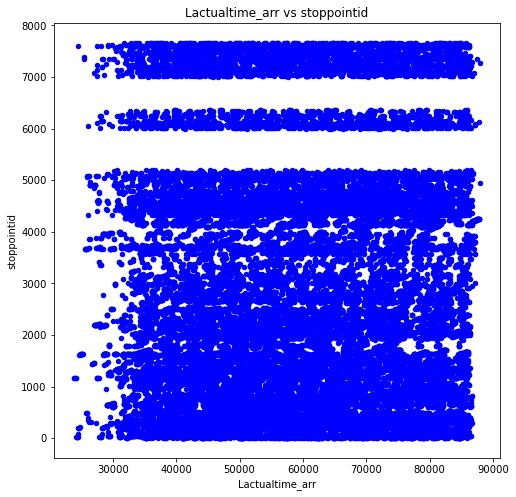

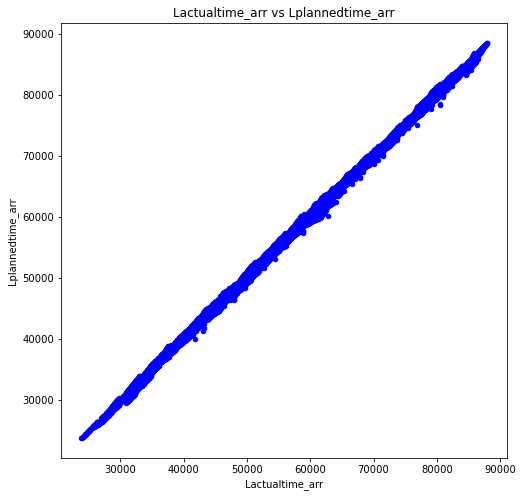

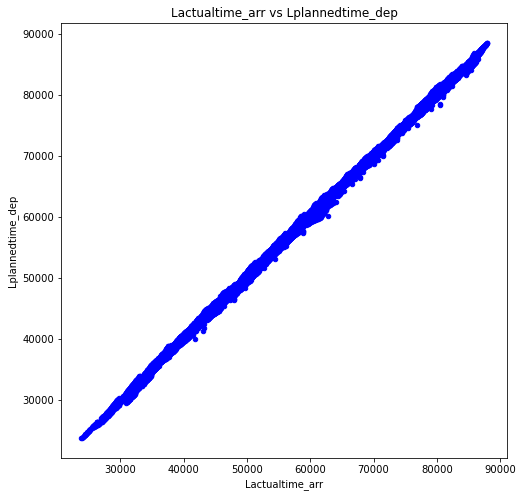

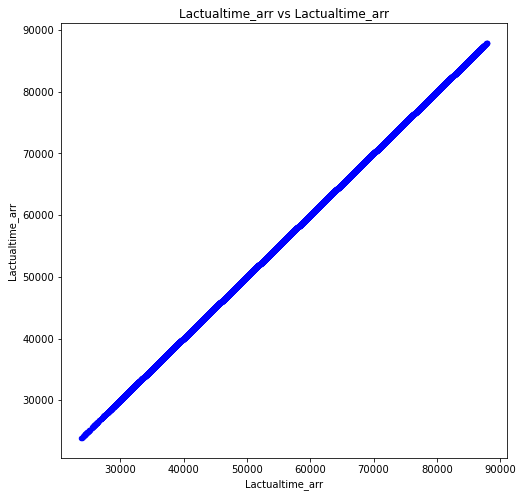

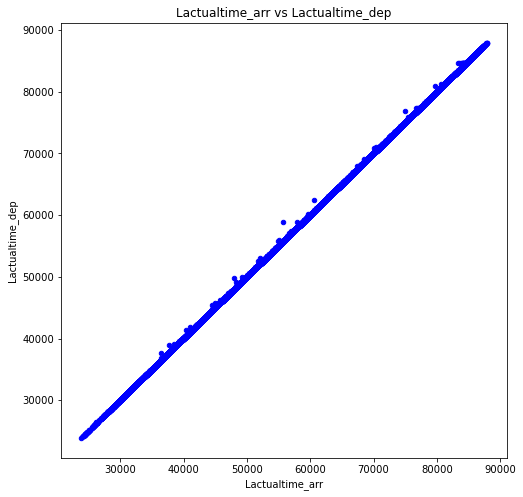

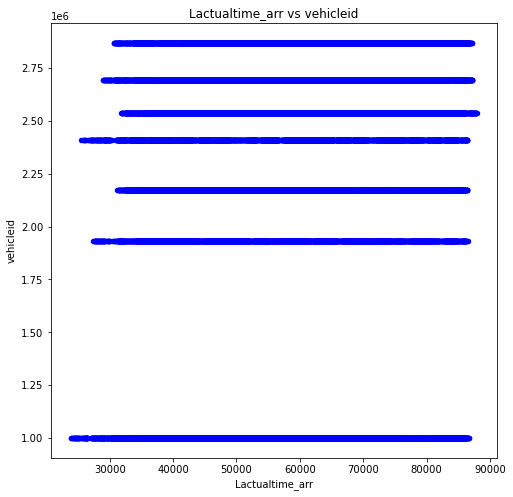

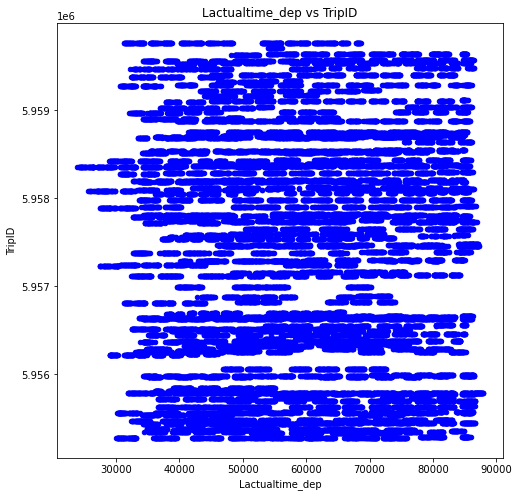

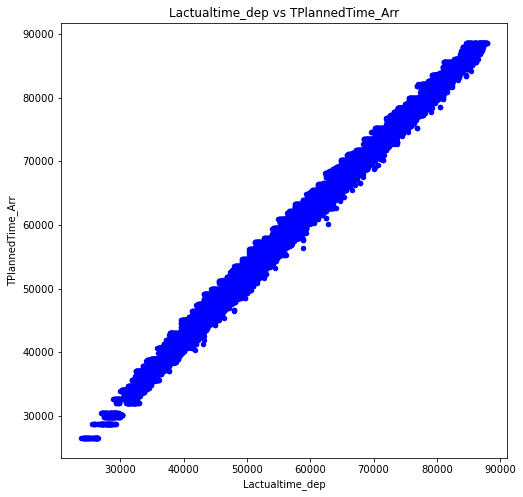

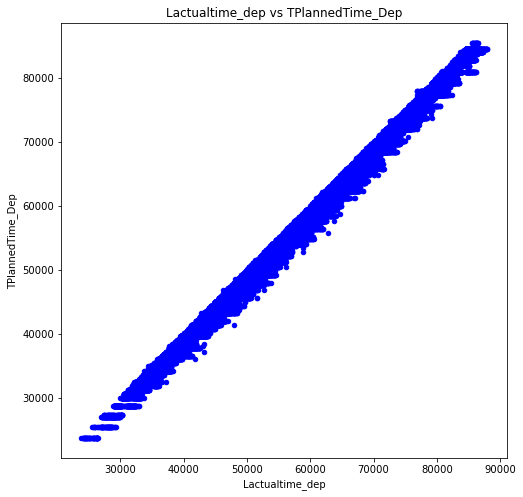

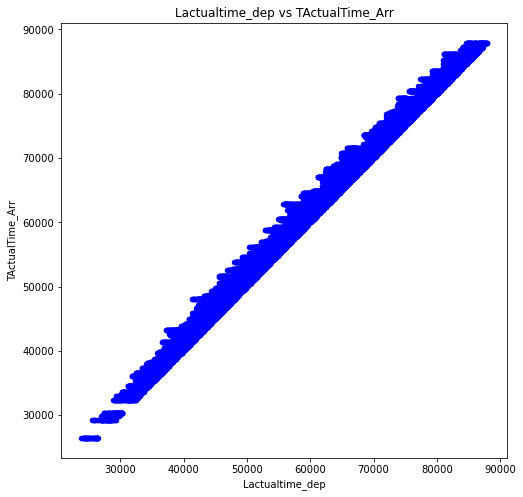

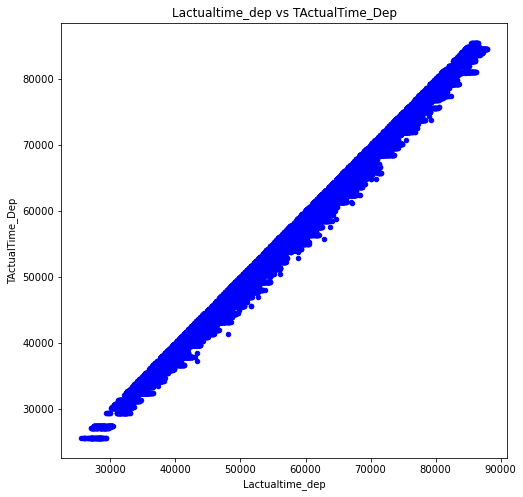

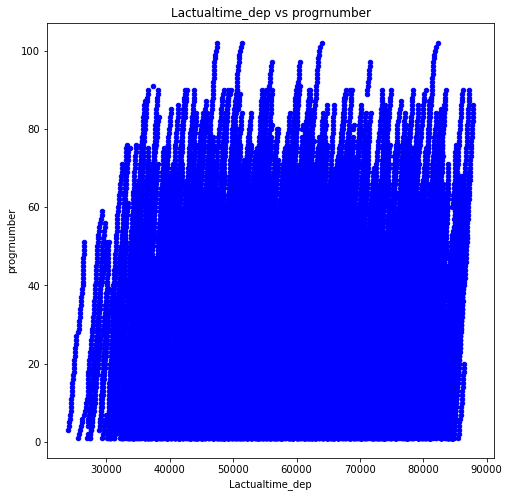

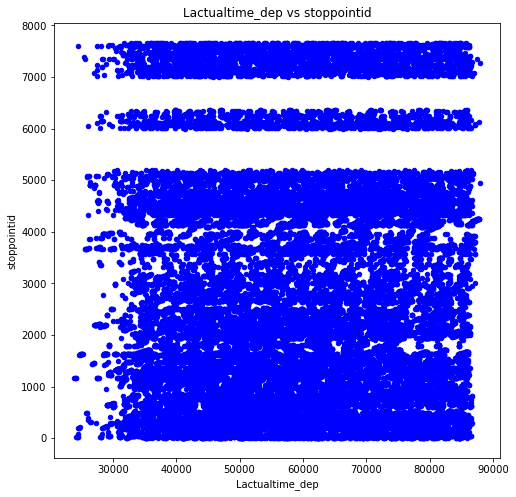

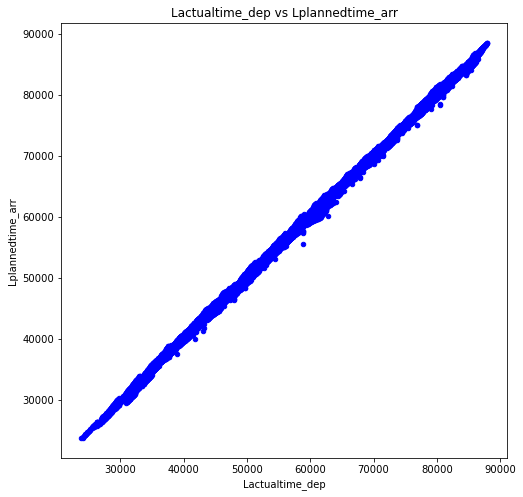

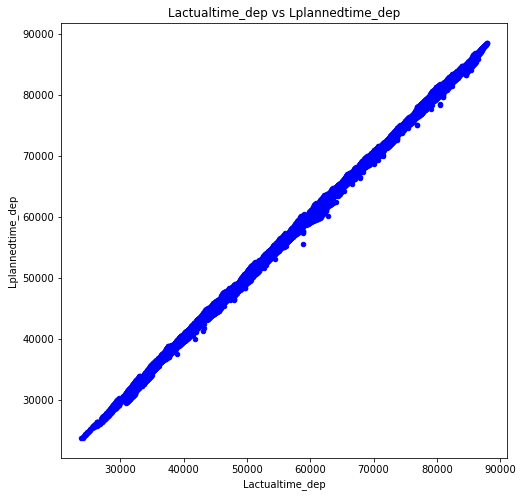

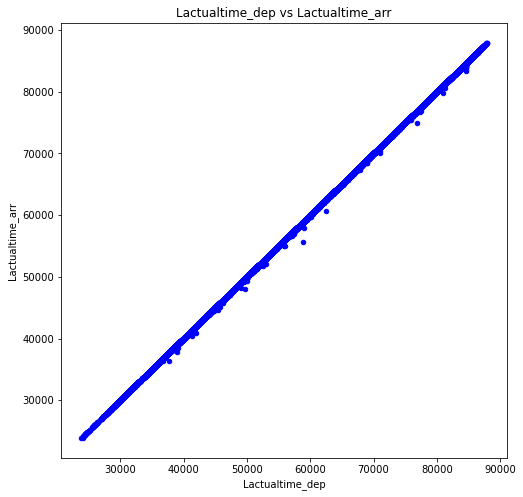

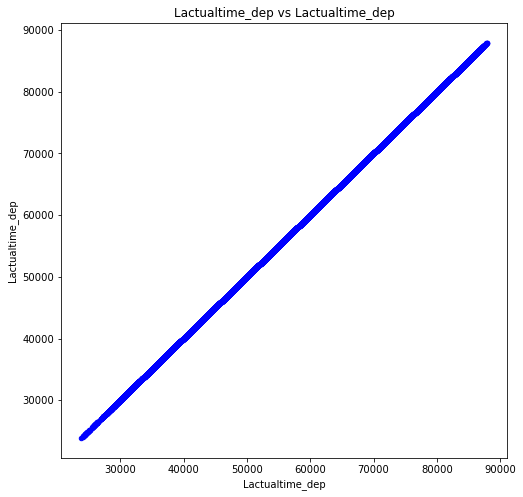

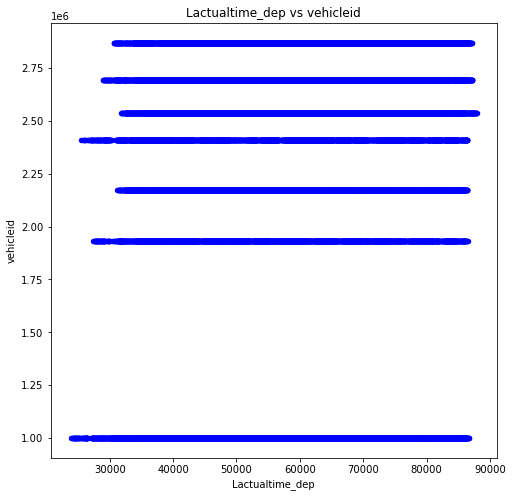

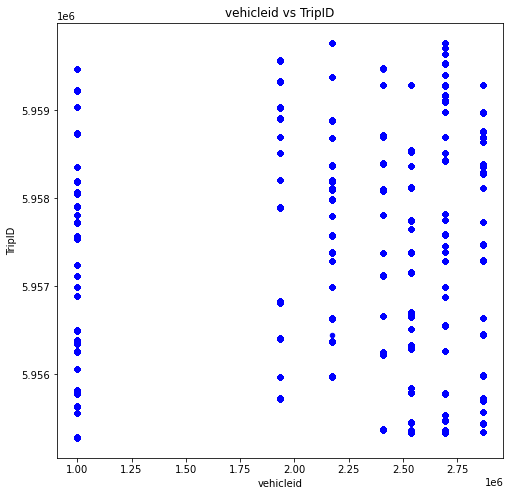

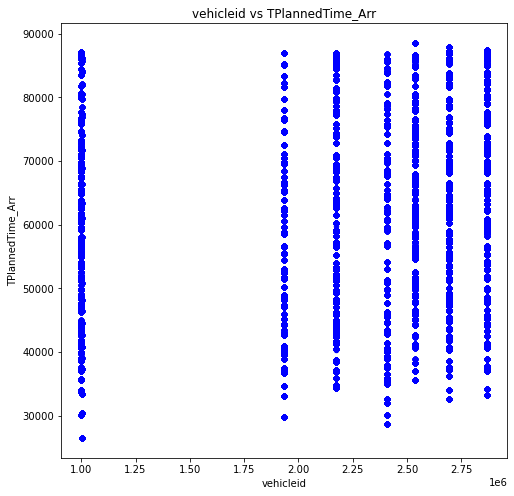

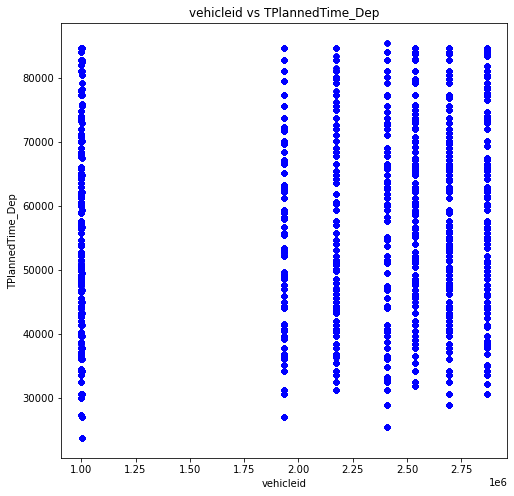

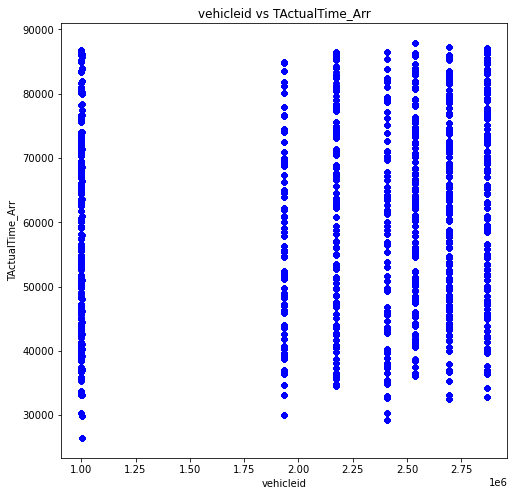

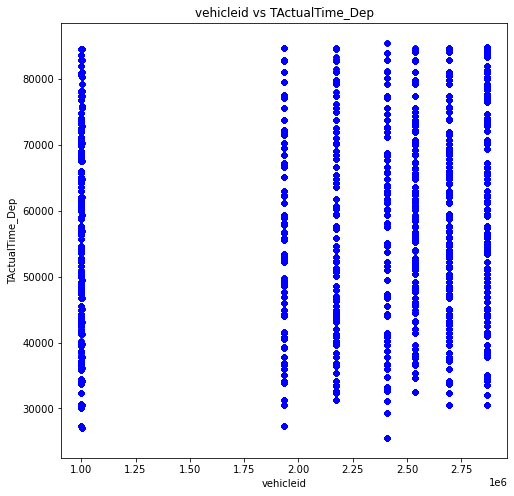

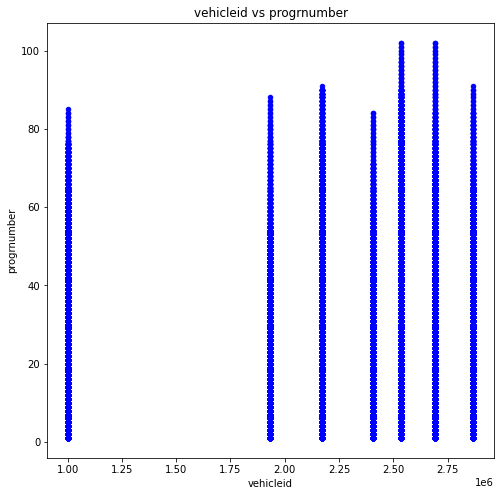

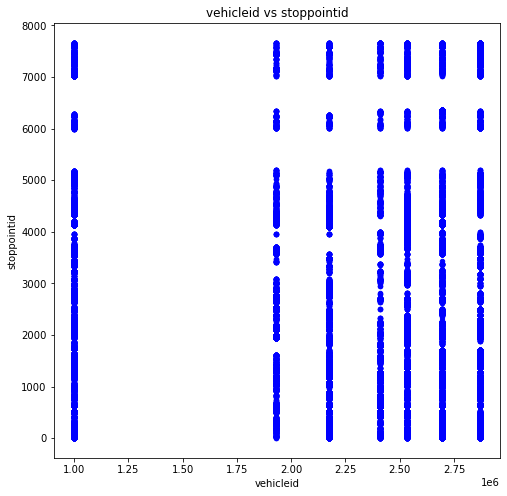

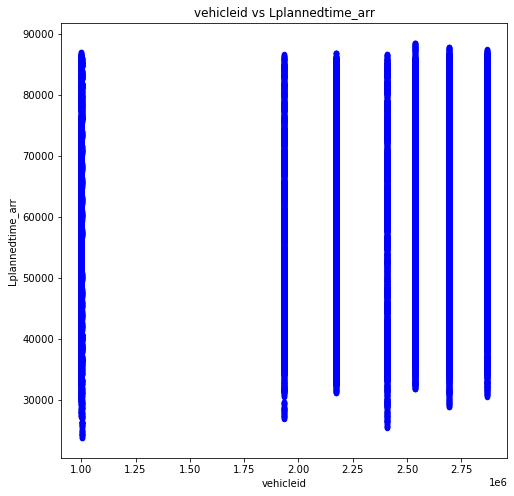

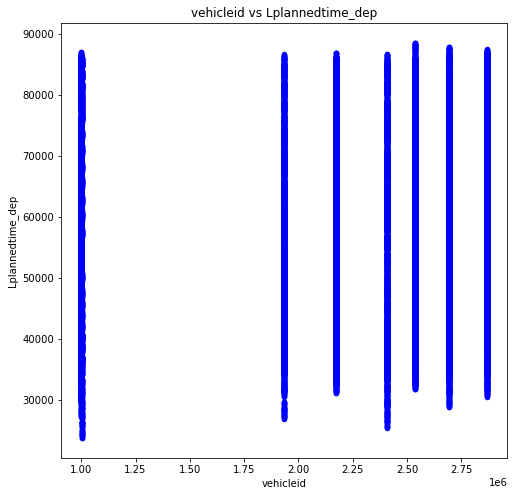

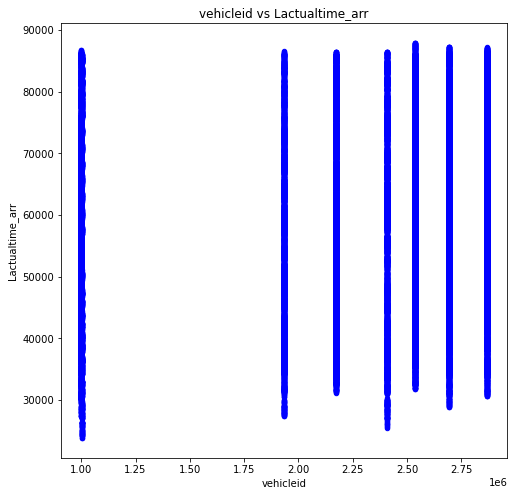

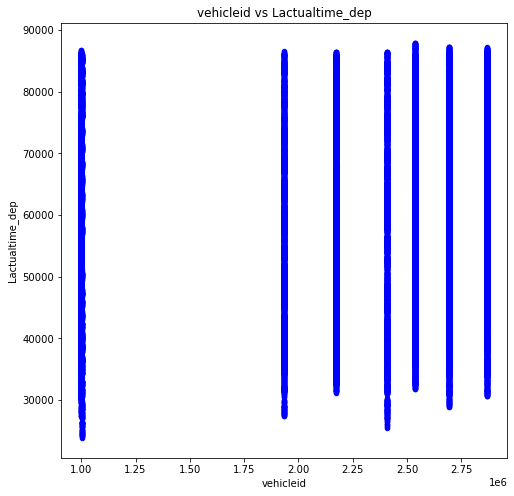

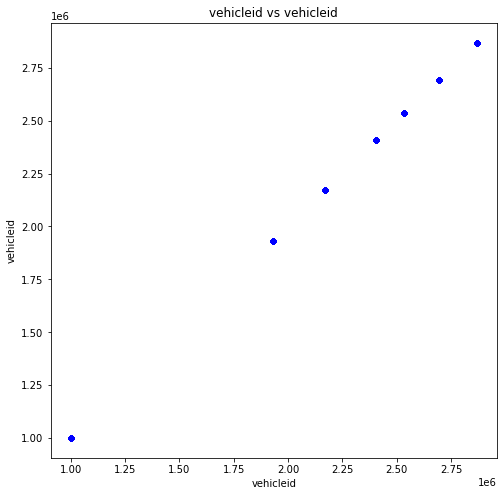

In [21]:
for feature in continuous_columns:
    for feature2 in continuous_columns:
        df.plot(kind='scatter', x=feature, y=feature2, color="b", figsize=(8,8), title=f"{feature} vs {feature2}")

# Datetime Features

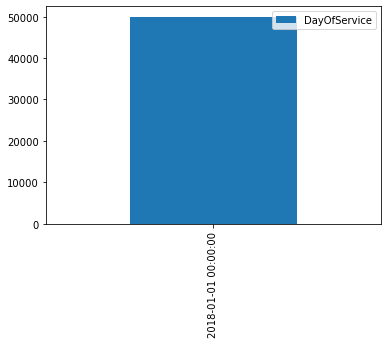

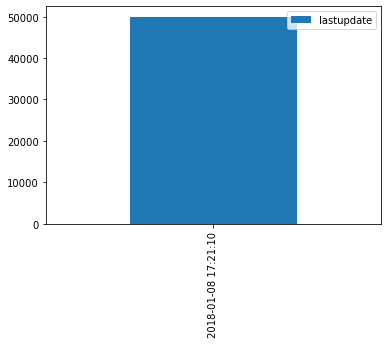

In [22]:
for col in datetime_columns:
    dates = pd.DataFrame(df[col].astype("datetime64[ns]").value_counts())
    dates.plot(kind="bar")
    plt.show()

# Categorical Features

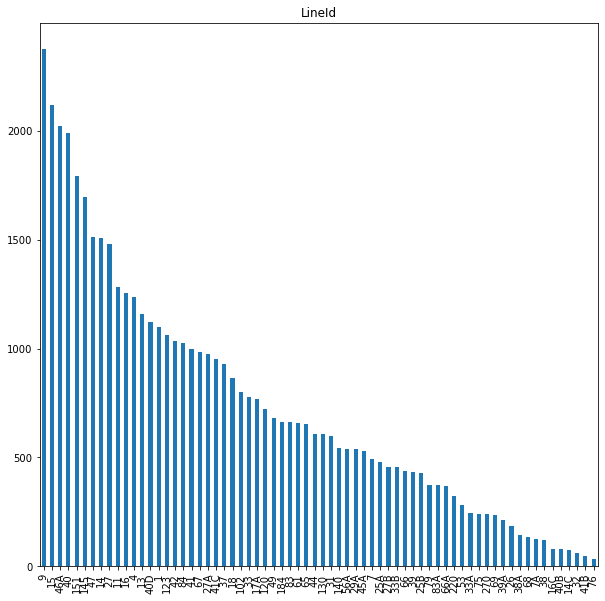

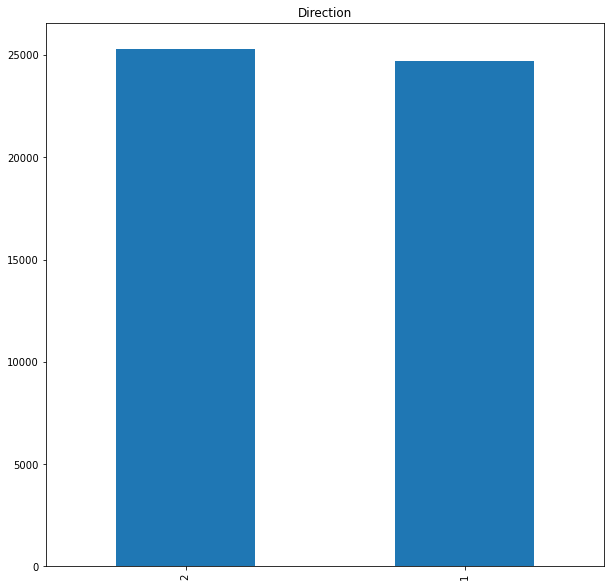

In [23]:
for col in categorical_columns:
    f = df[col].value_counts().plot(kind='bar', figsize=(10,10))
    plt.title(col)
    plt.show()

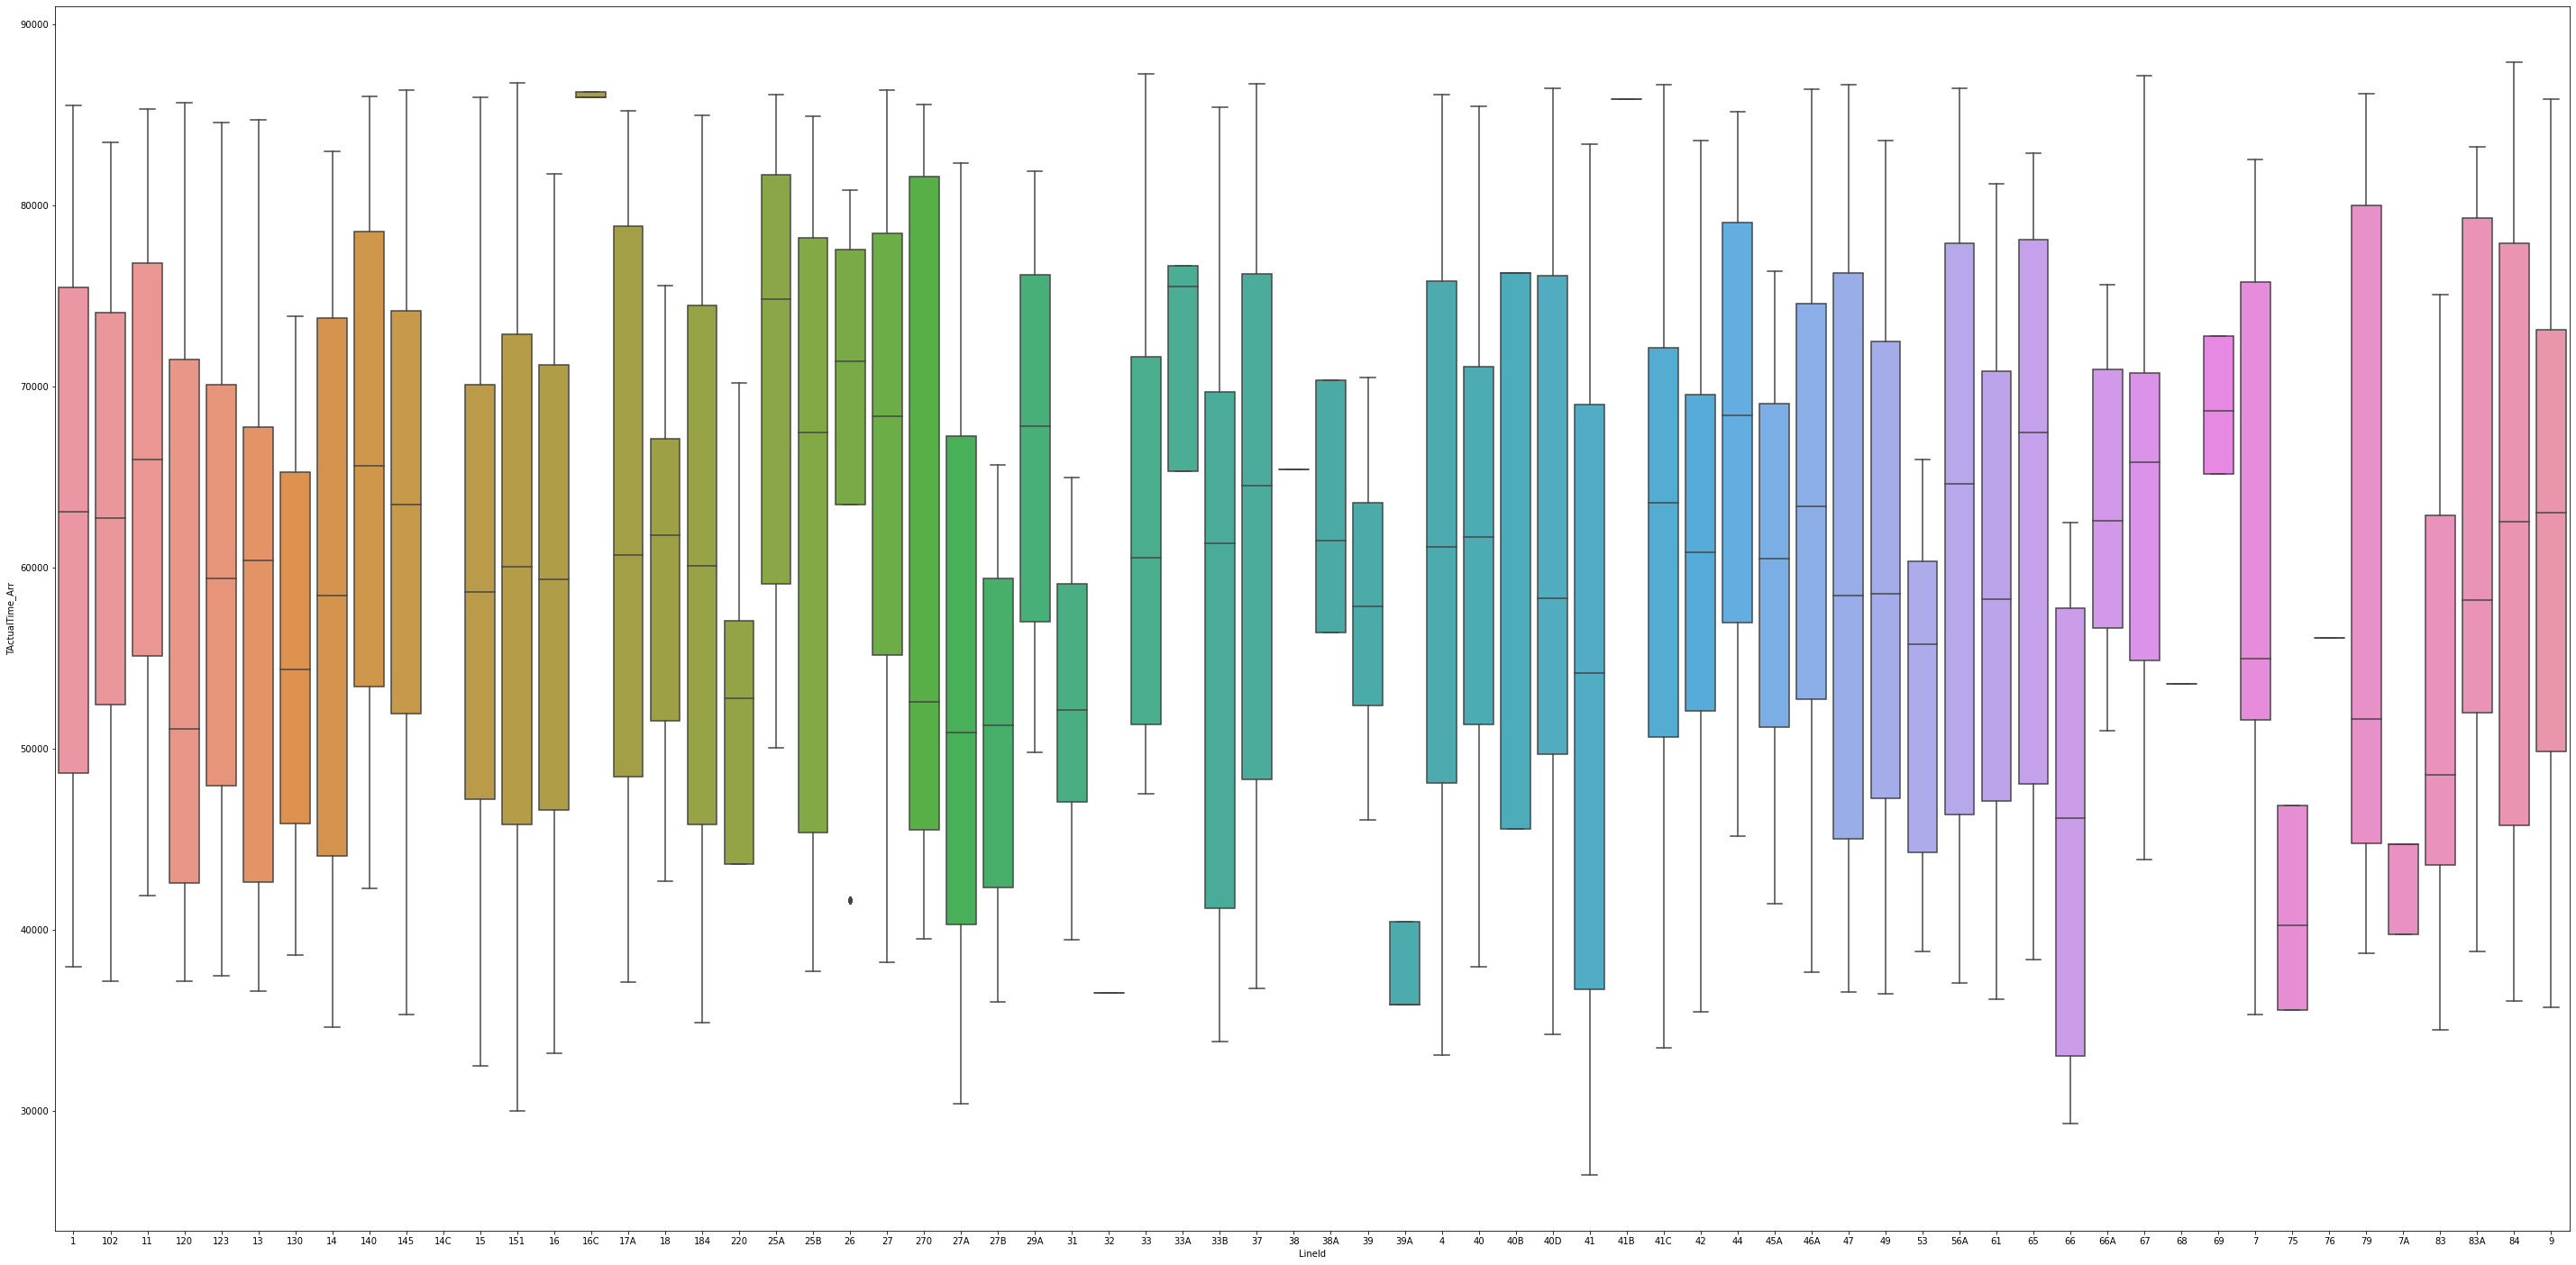

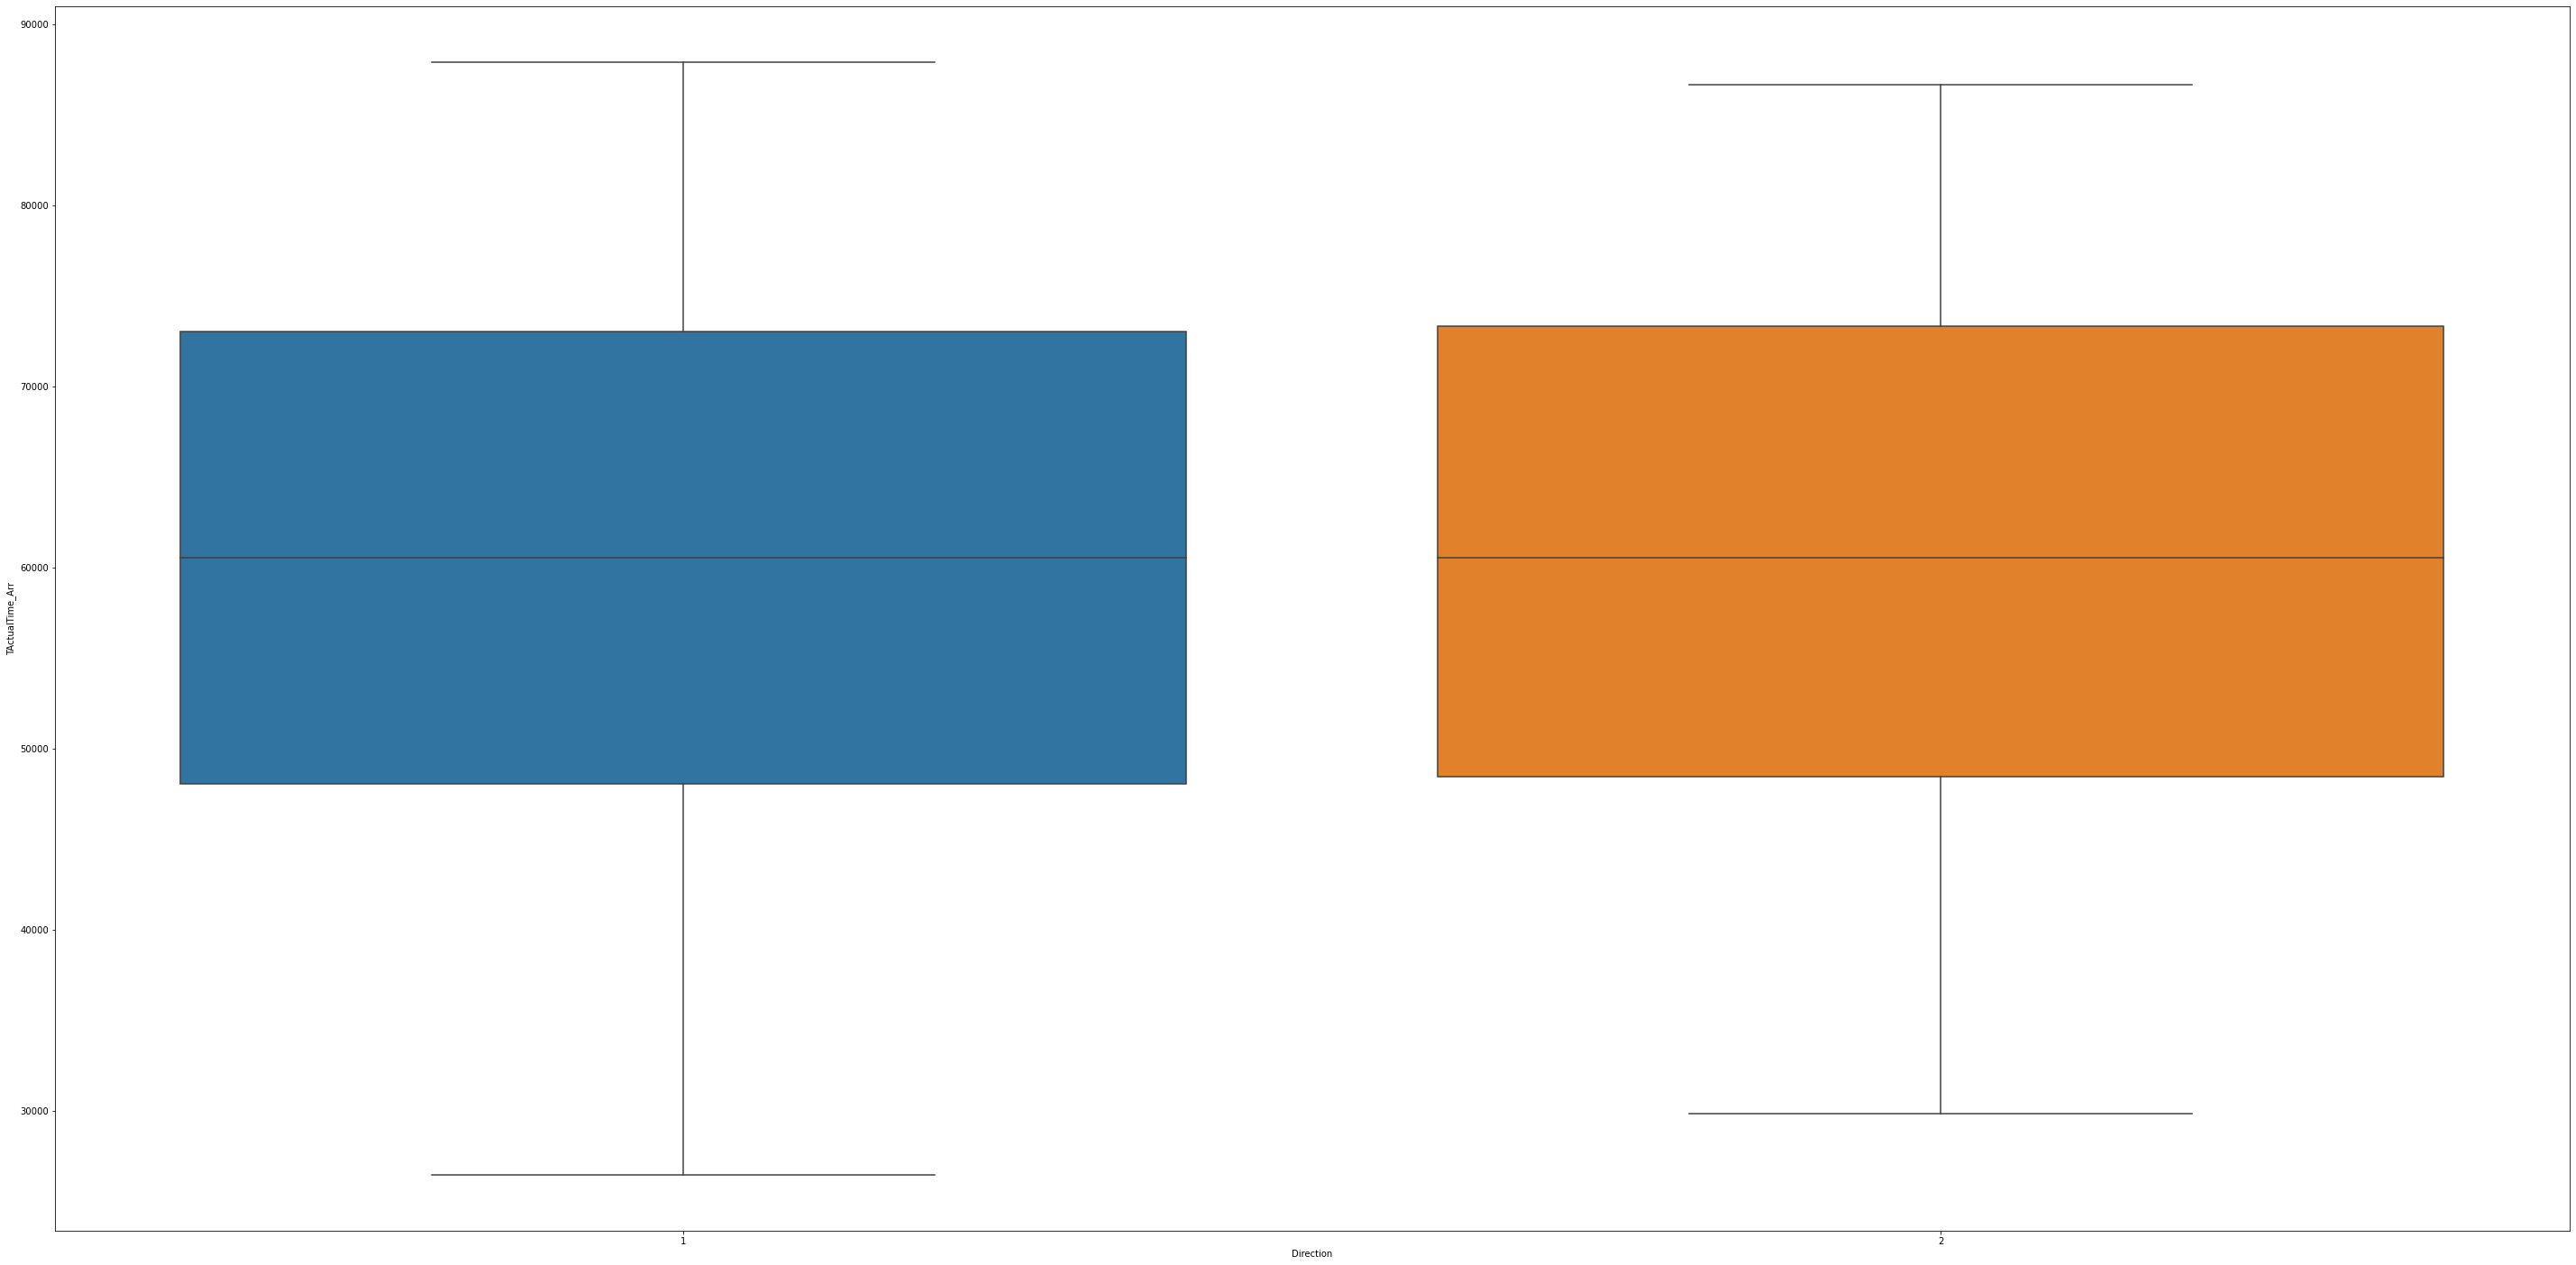

In [24]:
for feature in categorical_columns: 
    plt.figure(figsize=(50,25))
    sns.boxplot(data=df[[feature,"TActualTime_Arr"]], x=feature, y="TActualTime_Arr")
    plt.show()

# Findings

    - Duplicate cols
        - drop one of the duplicate cols
    - Null values
        - drop rows with actual time arrival missing as this is the target outcome, inpute/ create null category for actual time depart

In [25]:
arr_null = df[df["TActualTime_Arr"].isnull()].index

In [26]:
arr_null

Int64Index([ 1394,  1395,  1396,  1397,  1398,  1399,  1400,  1401,  1402,
             1403,
            ...
            49481, 49482, 49483, 49484, 49485, 49486, 49487, 49488, 49489,
            49490],
           dtype='int64', length=2097)

In [27]:
df = df.drop(arr_null)

In [28]:
df.shape

(47903, 16)

The best guess that we have for the actual time of departue is the planned time of departure

In [29]:
df["TActualTime_Dep"].fillna(df["TPlannedTime_Dep"], inplace=True)

In [30]:
df.isnull().sum()

DayOfService        0
TripID              0
LineId              0
Direction           0
TPlannedTime_Arr    0
TPlannedTime_Dep    0
TActualTime_Arr     0
TActualTime_Dep     0
progrnumber         0
stoppointid         0
Lplannedtime_arr    0
Lplannedtime_dep    0
Lactualtime_arr     0
Lactualtime_dep     0
vehicleid           0
lastupdate          0
dtype: int64

# Create Features

In [31]:
d = df["DayOfService"].astype("datetime64[ns]").dt.dayofweek

In [32]:
d

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: DayOfService, Length: 47903, dtype: int64

In [33]:
df.loc[d == 3]

Empty DataFrame
Columns: [DayOfService, TripID, LineId, Direction, TPlannedTime_Arr, TPlannedTime_Dep, TActualTime_Arr, TActualTime_Dep, progrnumber, stoppointid, Lplannedtime_arr, Lplannedtime_dep, Lactualtime_arr, Lactualtime_dep, vehicleid, lastupdate]
Index: []

In [34]:
d = df["DayOfService"].astype("datetime64[ns]").dt.dayofweek
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for val, day in enumerate(days):
    df[day] = 0
    df[day].loc[d == val] = 1 

C:\Users\frank\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [35]:
df

DayOfService     TripID LineId Direction  TPlannedTime_Arr  \
0      1514764800000000000  5955277.0     16         1           33932.0   
1      1514764800000000000  5955277.0     16         1           33932.0   
2      1514764800000000000  5955277.0     16         1           33932.0   
3      1514764800000000000  5955277.0     16         1           33932.0   
4      1514764800000000000  5955277.0     16         1           33932.0   
...                    ...        ...    ...       ...               ...   
49995  1514764800000000000  5959767.0     83         2           69259.0   
49996  1514764800000000000  5959767.0     83         2           69259.0   
49997  1514764800000000000  5959767.0     83         2           69259.0   
49998  1514764800000000000  5959767.0     83         2           69259.0   
49999  1514764800000000000  5959767.0     83         2           69259.0   

       TPlannedTime_Dep  TActualTime_Arr  TActualTime_Dep  progrnumber  \
0               30000.0          33184.0          30029.0         28.0   
1               30000.0          33184.0          30029.0         29.0   
2               30000.0          33184.0          30029.0         30.0   
3               30000.0          33184.0          30029.0         31.0   
4               30000.0          33184.0          30029.0         32.0   
...                 ...              ...              ...          ...   
49995           65400.0          68674.0          65469.0         21.0   
49996           65400.0          68674.0          65469.0         22.0   
49997           65400.0          68674.0          65469.0         23.0   
49998           65400.0          68674.0          65469.0         24.0   
49999           65400.0          68674.0          65469.0         25.0   

       stoppointid  Lplannedtime_arr  Lplannedtime_dep  Lactualtime_arr  \
0             45.0           31343.0           31343.0          31152.0   
1             46.0           31407.0           31407.0          31207.0   
2             47.0           31484.0           31484.0          31281.0   
3             48.0           31551.0           31551.0          31315.0   
4             49.0           31646.0           31646.0          31362.0   
...            ...               ...               ...              ...   
49995       1071.0           66293.0           66293.0          66354.0   
49996       4528.0           66348.0           66348.0          66382.0   
49997       1072.0           66424.0           66424.0          66467.0   
49998       1352.0           66542.0           66542.0          66581.0   
49999       1353.0           66596.0           66596.0          66645.0   

       Lactualtime_dep  vehicleid           lastupdate  Monday  Tuesday  \
0              31163.0  1001127.0  1515432070000000000       1        0   
1              31239.0  1001127.0  1515432070000000000       1        0   
2              31288.0  1001127.0  1515432070000000000       1        0   
3              31327.0  1001127.0  1515432070000000000       1        0   
4              31439.0  1001127.0  1515432070000000000       1        0   
...                ...        ...                  ...     ...      ...   
49995          66354.0  2693245.0  1515432070000000000       1        0   
49996          66382.0  2693245.0  1515432070000000000       1        0   
49997          66478.0  2693245.0  1515432070000000000       1        0   
49998          66620.0  2693245.0  1515432070000000000       1        0   
49999          66645.0  2693245.0  1515432070000000000       1        0   

       Wednesday  Thursday  Friday  Saturday  Sunday  
0              0         0       0         0       0  
1              0         0       0         0       0  
2              0         0       0         0       0  
3              0         0       0         0       0  
4              0         0       0         0       0  
...          ...       ...     ...       ...     ...  
49995          0         

# Weather Data

### Import the weather data

In [36]:
wdf = pd.read_csv("./RAW_DATA/weather_clean.csv")

### Examine the weather data

In [37]:
wdf.head()

weatherdate  rain  temp  wetb  dewpt  vappr  rhum    msl
0  2018-01-01 00:00:00   0.0   4.6   3.5    1.8    6.9    82  991.0
1  2018-01-01 01:00:00   0.1   4.7   3.6    1.8    7.0    81  991.1
2  2018-01-01 02:00:00   0.0   4.8   3.7    1.9    7.0    81  991.1
3  2018-01-01 03:00:00   0.0   4.9   3.8    2.2    7.2    82  990.7
4  2018-01-01 04:00:00   0.0   5.3   4.1    2.3    7.2    81  990.3

In [38]:
wdf.dtypes

weatherdate     object
rain           float64
temp           float64
wetb           float64
dewpt          float64
vappr          float64
rhum             int64
msl            float64
dtype: object

In [39]:
wdf["weatherdate"] = pd.to_datetime(wdf["weatherdate"]).astype('datetime64[ns]') 

In [40]:
wdf.head()

weatherdate  rain  temp  wetb  dewpt  vappr  rhum    msl
0 2018-01-01 00:00:00   0.0   4.6   3.5    1.8    6.9    82  991.0
1 2018-01-01 01:00:00   0.1   4.7   3.6    1.8    7.0    81  991.1
2 2018-01-01 02:00:00   0.0   4.8   3.7    1.9    7.0    81  991.1
3 2018-01-01 03:00:00   0.0   4.9   3.8    2.2    7.2    82  990.7
4 2018-01-01 04:00:00   0.0   5.3   4.1    2.3    7.2    81  990.3

# Merge Weather and Dublin Bus data

Create a shared column for actual arrival time, determine the weather for when the bus is planned to arrive to determine the weather in dublin at that time the bus is travelling

In [41]:
df["weatherdate"] = pd.to_datetime(df["DayOfService"]) + pd.to_timedelta(df["TPlannedTime_Arr"], unit='s')
df['weatherdate'] = df['weatherdate'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour))

In [42]:
df.head()

DayOfService     TripID LineId Direction  TPlannedTime_Arr  \
0  1514764800000000000  5955277.0     16         1           33932.0   
1  1514764800000000000  5955277.0     16         1           33932.0   
2  1514764800000000000  5955277.0     16         1           33932.0   
3  1514764800000000000  5955277.0     16         1           33932.0   
4  1514764800000000000  5955277.0     16         1           33932.0   

   TPlannedTime_Dep  TActualTime_Arr  TActualTime_Dep  progrnumber  \
0           30000.0          33184.0          30029.0         28.0   
1           30000.0          33184.0          30029.0         29.0   
2           30000.0          33184.0          30029.0         30.0   
3           30000.0          33184.0          30029.0         31.0   
4           30000.0          33184.0          30029.0         32.0   

   stoppointid  Lplannedtime_arr  Lplannedtime_dep  Lactualtime_arr  \
0         45.0           31343.0           31343.0          31152.0   
1         46.0           31407.0           31407.0          31207.0   
2         47.0           31484.0           31484.0          31281.0   
3         48.0           31551.0           31551.0          31315.0   
4         49.0           31646.0           31646.0          31362.0   

   Lactualtime_dep  vehicleid           lastupdate  Monday  Tuesday  \
0          31163.0  1001127.0  1515432070000000000       1        0   
1          31239.0  1001127.0  1515432070000000000       1        0   
2          31288.0  1001127.0  1515432070000000000       1        0   
3          31327.0  1001127.0  1515432070000000000       1        0   
4          31439.0  1001127.0  1515432070000000000       1        0   

   Wednesday  Thursday  Friday  Saturday  Sunday         weatherdate  
0          0         0       0         0       0 2018-01-01 09:00:00  
1          0         0       0         0       0 2018-01-01 09:00:00  
2          0         0       0         0       0 2018-01-01 09:00:00  
3          0         0       0         0       0 2018-01-01 09:00:00  
4          0         0       0         0       0 2018-01-01 09:00:00

merge the weather and dublin bus on this new column

In [43]:
final = pd.merge(df,wdf, on='weatherdate')

In [44]:
final.columns

Index(['DayOfService', 'TripID', 'LineId', 'Direction', 'TPlannedTime_Arr',
       'TPlannedTime_Dep', 'TActualTime_Arr', 'TActualTime_Dep', 'progrnumber',
       'stoppointid', 'Lplannedtime_arr', 'Lplannedtime_dep',
       'Lactualtime_arr', 'Lactualtime_dep', 'vehicleid', 'lastupdate',
       'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday', 'weatherdate', 'rain', 'temp', 'wetb', 'dewpt', 'vappr',
       'rhum', 'msl'],
      dtype='object')

remove the weather date column as no longer necessary

In [45]:
final = final.drop('weatherdate', 1)

# Inspect the new dataframe

In [46]:
final.shape

(47903, 30)

In [47]:
final.head()

DayOfService     TripID LineId Direction  TPlannedTime_Arr  \
0  1514764800000000000  5955277.0     16         1           33932.0   
1  1514764800000000000  5955277.0     16         1           33932.0   
2  1514764800000000000  5955277.0     16         1           33932.0   
3  1514764800000000000  5955277.0     16         1           33932.0   
4  1514764800000000000  5955277.0     16         1           33932.0   

   TPlannedTime_Dep  TActualTime_Arr  TActualTime_Dep  progrnumber  \
0           30000.0          33184.0          30029.0         28.0   
1           30000.0          33184.0          30029.0         29.0   
2           30000.0          33184.0          30029.0         30.0   
3           30000.0          33184.0          30029.0         31.0   
4           30000.0          33184.0          30029.0         32.0   

   stoppointid  Lplannedtime_arr  Lplannedtime_dep  Lactualtime_arr  \
0         45.0           31343.0           31343.0          31152.0   
1         46.0           31407.0           31407.0          31207.0   
2         47.0           31484.0           31484.0          31281.0   
3         48.0           31551.0           31551.0          31315.0   
4         49.0           31646.0           31646.0          31362.0   

   Lactualtime_dep  vehicleid           lastupdate  Monday  Tuesday  \
0          31163.0  1001127.0  1515432070000000000       1        0   
1          31239.0  1001127.0  1515432070000000000       1        0   
2          31288.0  1001127.0  1515432070000000000       1        0   
3          31327.0  1001127.0  1515432070000000000       1        0   
4          31439.0  1001127.0  1515432070000000000       1        0   

   Wednesday  Thursday  Friday  Saturday  Sunday  rain  temp  wetb  dewpt  \
0          0         0       0         0       0   0.0   4.5   3.5    1.9   
1          0         0       0         0       0   0.0   4.5   3.5    1.9   
2          0         0       0         0       0   0.0   4.5   3.5    1.9   
3          0         0       0         0       0   0.0   4.5   3.5    1.9   
4          0         0       0         0       0   0.0   4.5   3.5    1.9   

   vappr  rhum    msl  
0    7.0    83  992.4  
1    7.0    83  992.4  
2    7.0    83  992.4  
3    7.0    83  992.4  
4    7.0    83  992.4

# Prepare the datframe for the model

In [48]:
final = pd.get_dummies(final)

In [49]:
y = final["Lactualtime_arr"]

In [50]:
X_col = list(final.columns)
X_col.remove("Lactualtime_arr")

In [51]:
X = final[X_col]

### As the data is timeseries split the data accordingly

In [52]:
test_size = int(X.shape[0] * 0.7)

In [53]:
X_train, X_test, y_train, y_test = X.loc[final.index[:test_size]], X.loc[final.index[test_size:]], y.loc[final.index[:test_size]], y.loc[final.index[test_size:]]

In [54]:
X_train.shape

(33532, 97)

In [55]:
features = X_train.columns

### Fit a linear regression model on the data

In [56]:
linreg = LinearRegression().fit(X_train, y_train)

In [57]:
results = linreg.predict(X_train)

In [58]:
print("MAE", metrics.mean_absolute_error(y_train, results))
print("MSE",metrics.mean_squared_error(y_train, results))
print("RMSE",np.sqrt(metrics.mean_squared_error(y_train, results)))

MAE 9.979465780441764
MSE 905.3226195009096
RMSE 30.088579552729133


In [59]:
mean_time_error = sum(abs(y_train - results))/ len(y_train)

### Get the average difference in time in minuites and seconds compared to the actual time

In [60]:
str(pd.to_timedelta(mean_time_error, unit='s'))

'0 days 00:00:09.979465'

In [61]:
results = linreg.predict(X_test)

In [62]:
print("MAE", metrics.mean_absolute_error(y_test, results))
print("MSE",metrics.mean_squared_error(y_test, results))
print("RMSE",np.sqrt(metrics.mean_squared_error(y_test, results)))

MAE 9.587610752956163
MSE 688.704201656363
RMSE 26.243174382234383


In [63]:
mean_time_error = sum(abs(y_test - results))/ len(y_test)
str(pd.to_timedelta(mean_time_error, unit='s'))

'0 days 00:00:09.587610'

In [64]:
print("Features: \n", features)
print("\nCoeficients: \n", linreg.coef_)
print("\nIntercept: \n", linreg.intercept_)

Features: 
 Index(['DayOfService', 'TripID', 'TPlannedTime_Arr', 'TPlannedTime_Dep',
       'TActualTime_Arr', 'TActualTime_Dep', 'progrnumber', 'stoppointid',
       'Lplannedtime_arr', 'Lplannedtime_dep', 'Lactualtime_dep', 'vehicleid',
       'lastupdate', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday', 'Sunday', 'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum',
       'msl', 'LineId_1', 'LineId_102', 'LineId_11', 'LineId_120',
       'LineId_123', 'LineId_13', 'LineId_130', 'LineId_14', 'LineId_140',
       'LineId_145', 'LineId_14C', 'LineId_15', 'LineId_151', 'LineId_16',
       'LineId_16C', 'LineId_17A', 'LineId_18', 'LineId_184', 'LineId_220',
       'LineId_25A', 'LineId_25B', 'LineId_26', 'LineId_27', 'LineId_270',
       'LineId_27A', 'LineId_27B', 'LineId_29A', 'LineId_31', 'LineId_32',
       'LineId_33', 'LineId_33A', 'LineId_33B', 'LineId_37', 'LineId_38',
       'LineId_38A', 'LineId_39', 'LineId_39A', 'LineId_4', 'LineId_40',
       'LineId_

In [65]:
importance = pd.DataFrame({'feature': features, 'importance':linreg.coef_})
importance.sort_values('importance', ascending=False)

feature    importance
23             dewpt  1.175403e+01
56         LineId_33  9.589989e+00
66        LineId_40B  7.903063e+00
45        LineId_220  6.841418e+00
93         LineId_84  6.796778e+00
84         LineId_68  6.219905e+00
80         LineId_65  4.863461e+00
90         LineId_7A  4.500889e+00
24             vappr  4.376169e+00
40         LineId_16  3.693137e+00
32         LineId_13  3.623526e+00
49         LineId_27  2.988968e+00
44        LineId_184  2.687502e+00
77         LineId_53  1.980978e+00
85         LineId_69  1.944157e+00
43         LineId_18  1.662963e+00
42        LineId_17A  1.478776e+00
39        LineId_151  1.397392e+00
87         LineId_75  1.310357e+00
79         LineId_61  1.190510e+00
83         LineId_67  1.161146e+00
52        LineId_27B  1.091581e+00
65         LineId_40  1.081907e+00
63        LineId_39A  1.047157e+00
10   Lactualtime_dep  9.801509e-01
86          LineId_7  9.315794e-01
78        LineId_56A  8.750680e-01
46        LineId_25A  8.584937e-01
61        LineId_38A  5.414520e-01
59         LineId_37  5.273532e-01
72         LineId_44  4.972816e-01
57        LineId_33A  4.152626e-01
36        LineId_145  2.366873e-01
47        LineId_25B  2.320056e-01
6        progrnumber  1.722158e-01
28        LineId_102  1.512970e-01
96       Direction_2  7.546144e-02
5    TActualTime_Dep  1.558381e-02
9   Lplannedtime_dep  7.522517e-03
8   Lplannedtime_arr  7.522419e-03
7        stoppointid  1.991534e-04
1             TripID  1.875777e-04
4    TActualTime_Arr  2.228821e-05
0       DayOfService  2.619330e-10
15         Wednesday  3.651079e-12
19            Sunday  3.552714e-15
55         LineId_32  4.440892e-16
88         LineId_76  0.000000e+00
37        LineId_14C -7.105427e-15
12        lastupdate -1.443290e-14
18          Saturday -1.305622e-13
17            Friday -3.965717e-13
16          Thursday -1.415978e-12
14           Tuesday -4.704903e-12
13            Monday -1.701383e-11
11         vehicleid -4.805393e-07
2   TPlannedTime_Arr -2.101314e-03
3   TPlannedTime_Dep -8.630014e-03
41        LineId_16C -4.173288e-02
95       Direction_1 -7.546144e-02
58        LineId_33B -1.230771e-01
26               msl -2.005319e-01
73        LineId_45A -2.967284e-01
91         LineId_83 -3.512972e-01
62         LineId_39 -3.870495e-01
71         LineId_42 -4.677661e-01
34         LineId_14 -6.388724e-01
69        LineId_41B -6.681510e-01
64          LineId_4 -1.161717e+00
70        LineId_41C -1.193636e+00
81         LineId_66 -1.274888e+00
94          LineId_9 -1.358797e+00
53        LineId_29A -1.431543e+00
51        LineId_27A -1.462879e+00
74        LineId_46A -1.474545e+00
82        LineId_66A -1.541103e+00
68         LineId_41 -1.683524e+00
25              rhum -1.758823e+00
31        LineId_123 -1.777832e+00
92        LineId_83A -1.785342e+00
30        LineId_120 -2.062277e+00
76         LineId_49 -2.067803e+00
60         LineId_38 -2.416427e+00
38         LineId_15 -2.425046e+00
54         LineId_31 -2.637491e+00
89         LineId_79 -2.934467e+00
27          LineId_1 -2.972096e+00
33        LineId_130 -3.247608e+00
67        LineId_40D -3.374243e+00
75         LineId_47 -3.796497e+00
29         LineId_11 -3.928811e+00
22              wetb -6.778548e+00
35        LineId_140 -6.938476e+00
48         LineId_26 -7.349823e+00
21              temp -7.440538e+00
20              rain -1.416100e+01
50        LineId_270 -1.505050e+01

In [66]:
rf = RandomForestRegressor(random_state=0).fit(X_train, y_train)

In [67]:
importance = pd.DataFrame({'feature': features, 'importance':rf.feature_importances_})
importance.sort_values('importance', ascending=False)

feature    importance
10   Lactualtime_dep  9.999944e-01
8   Lplannedtime_arr  1.226919e-06
9   Lplannedtime_dep  1.135416e-06
26               msl  1.047606e-06
2   TPlannedTime_Arr  3.286057e-07
7        stoppointid  2.260028e-07
6        progrnumber  1.830313e-07
5    TActualTime_Dep  1.154496e-07
3   TPlannedTime_Dep  1.149416e-07
75         LineId_47  1.126344e-07
4    TActualTime_Arr  1.095936e-07
1             TripID  9.177681e-08
50        LineId_270  8.956562e-08
67        LineId_40D  8.484381e-08
11         vehicleid  6.847989e-08
93         LineId_84  6.406177e-08
21              temp  6.147578e-08
49         LineId_27  5.480789e-08
38         LineId_15  4.545480e-08
48         LineId_26  4.034979e-08
32         LineId_13  3.054260e-08
25              rhum  3.052217e-08
23             dewpt  2.552571e-08
22              wetb  2.501907e-08
24             vappr  2.450191e-08
29         LineId_11  2.352266e-08
94          LineId_9  2.091829e-08
64          LineId_4  1.715154e-08
40         LineId_16  1.650445e-08
39        LineId_151  1.338722e-08
74        LineId_46A  1.231153e-08
83         LineId_67  1.213319e-08
27          LineId_1  1.114741e-08
72         LineId_44  1.071101e-08
68         LineId_41  9.939230e-09
36        LineId_145  9.407570e-09
31        LineId_123  9.308302e-09
96       Direction_2  7.637908e-09
34         LineId_14  7.331437e-09
95       Direction_1  6.958143e-09
65         LineId_40  6.687238e-09
35        LineId_140  6.120214e-09
28        LineId_102  5.690905e-09
82        LineId_66A  4.217580e-09
54         LineId_31  4.136849e-09
59         LineId_37  3.505020e-09
70        LineId_41C  2.991421e-09
91         LineId_83  2.851188e-09
92        LineId_83A  2.653745e-09
62         LineId_39  2.551585e-09
81         LineId_66  2.292648e-09
71         LineId_42  2.071053e-09
33        LineId_130  1.797535e-09
47        LineId_25B  1.592211e-09
42        LineId_17A  1.233076e-09
52        LineId_27B  1.127309e-09
73        LineId_45A  1.061496e-09
80         LineId_65  9.242115e-10
30        LineId_120  8.938976e-10
76         LineId_49  8.689115e-10
46        LineId_25A  8.450886e-10
56         LineId_33  8.404841e-10
79         LineId_61  8.359588e-10
43         LineId_18  8.323887e-10
51        LineId_27A  8.084031e-10
53        LineId_29A  7.833878e-10
89         LineId_79  7.676470e-10
78        LineId_56A  7.385344e-10
44        LineId_184  5.988688e-10
20              rain  4.291766e-10
45        LineId_220  3.834741e-10
86          LineId_7  3.829641e-10
58        LineId_33B  3.531159e-10
77         LineId_53  2.987500e-10
87         LineId_75  2.543421e-10
57        LineId_33A  2.540270e-10
85         LineId_69  2.174059e-10
63        LineId_39A  1.906940e-10
69        LineId_41B  9.889922e-11
61        LineId_38A  9.475897e-11
60         LineId_38  9.473317e-11
84         LineId_68  5.247287e-11
41        LineId_16C  3.556104e-11
90         LineId_7A  2.892427e-11
66        LineId_40B  9.463296e-12
13            Monday  0.000000e+00
12        lastupdate  0.000000e+00
37        LineId_14C  0.000000e+00
19            Sunday  0.000000e+00
88         LineId_76  0.000000e+00
14           Tuesday  0.000000e+00
15         Wednesday  0.000000e+00
16          Thursday  0.000000e+00
17            Friday  0.000000e+00
18          Saturday  0.000000e+00
55         LineId_32  0.000000e+00
0       DayOfService  0.000000e+00

In [68]:
results = rf.predict(X_test)

In [69]:
print("MAE", metrics.mean_absolute_error(y_test, results))
print("MSE",metrics.mean_squared_error(y_test, results))
print("RMSE",np.sqrt(metrics.mean_squared_error(y_test, results)))

MAE 46.59991719434976
MSE 76847.12070406378
RMSE 277.2131322720188


In [70]:
mean_time_error = sum(abs(y_test - results))/ len(y_test)
str(pd.to_timedelta(mean_time_error, unit='s'))

'0 days 00:00:46.599917'

In [71]:
final.head()

DayOfService     TripID  TPlannedTime_Arr  TPlannedTime_Dep  \
0  1514764800000000000  5955277.0           33932.0           30000.0   
1  1514764800000000000  5955277.0           33932.0           30000.0   
2  1514764800000000000  5955277.0           33932.0           30000.0   
3  1514764800000000000  5955277.0           33932.0           30000.0   
4  1514764800000000000  5955277.0           33932.0           30000.0   

   TActualTime_Arr  TActualTime_Dep  progrnumber  stoppointid  \
0          33184.0          30029.0         28.0         45.0   
1          33184.0          30029.0         29.0         46.0   
2          33184.0          30029.0         30.0         47.0   
3          33184.0          30029.0         31.0         48.0   
4          33184.0          30029.0         32.0         49.0   

   Lplannedtime_arr  Lplannedtime_dep  Lactualtime_arr  Lactualtime_dep  \
0           31343.0           31343.0          31152.0          31163.0   
1           31407.0           31407.0          31207.0          31239.0   
2           31484.0           31484.0          31281.0          31288.0   
3           31551.0           31551.0          31315.0          31327.0   
4           31646.0           31646.0          31362.0          31439.0   

   vehicleid           lastupdate  Monday  Tuesday  Wednesday  Thursday  \
0  1001127.0  1515432070000000000       1        0          0         0   
1  1001127.0  1515432070000000000       1        0          0         0   
2  1001127.0  1515432070000000000       1        0          0         0   
3  1001127.0  1515432070000000000       1        0          0         0   
4  1001127.0  1515432070000000000       1        0          0         0   

   Friday  Saturday  Sunday  rain  temp  wetb  dewpt  vappr  rhum    msl  \
0       0         0       0   0.0   4.5   3.5    1.9    7.0    83  992.4   
1       0         0       0   0.0   4.5   3.5    1.9    7.0    83  992.4   
2       0         0       0   0.0   4.5   3.5    1.9    7.0    83  992.4   
3       0         0       0   0.0   4.5   3.5    1.9    7.0    83  992.4   
4       0         0       0   0.0   4.5   3.5    1.9    7.0    83  992.4   

   LineId_1  LineId_102  LineId_11  LineId_120  LineId_123  LineId_13  \
0         0           0          0           0           0          0   
1         0           0          0           0           0          0   
2         0           0          0           0           0          0   
3         0           0          0           0           0          0   
4         0           0          0           0           0          0   

   LineId_130  LineId_14  LineId_140  LineId_145  LineId_14C  LineId_15  \
0           0          0           0           0           0          0   
1           0          0           0           0           0          0   
2           0          0           0           0           0          0   
3           0          0           0           0           0          0   
4           0          0           0           0           0          0   

   LineId_151  LineId_16  LineId_16C  LineId_17A  LineId_18  LineId_184  \
0           0          1           0           0          0           0   
1           0          1           0           0          0           0   
2           0          1           0           0          0           0   
3           0          1           0           0          0           0   
4           0          1           0           0          0           0   

   LineId_220  LineId_25A  LineId_25B  LineId_26  LineId_27  LineId_270  \
0           0           0           0          0          0           0   
1           0           0           0          0          0           0   
2           0           0           0          0          0           0   
3           0           0           0          0          0           0   
4           0           0           0          0          0           0   

   LineId_27A  LineId_27B  Li

In [261]:
final_features = list(X_train.columns)
dropped_features = ['DayOfService','wetb','dewpt','vappr','progrnumber', 'TripID','TActualTime_Dep', 'TActualTime_Arr', 'Lplannedtime_arr', 'Lplannedtime_dep', 'Lactualtime_dep', 'vehicleid', 'lastupdate', 'Direction_1', 'Direction_2', 'TPlannedTime_Dep']
for feature in dropped_features:
    print(feature)
    final_features.remove(feature)

print(final_features)

DayOfService
wetb
dewpt
vappr
progrnumber
TripID
TActualTime_Dep
TActualTime_Arr
Lplannedtime_arr
Lplannedtime_dep
Lactualtime_dep
vehicleid
lastupdate
Direction_1
Direction_2
TPlannedTime_Dep
['TPlannedTime_Arr', 'stoppointid', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'rain', 'temp', 'rhum', 'msl', 'LineId_1', 'LineId_102', 'LineId_11', 'LineId_120', 'LineId_123', 'LineId_13', 'LineId_130', 'LineId_14', 'LineId_140', 'LineId_145', 'LineId_14C', 'LineId_15', 'LineId_151', 'LineId_16', 'LineId_16C', 'LineId_17A', 'LineId_18', 'LineId_184', 'LineId_220', 'LineId_25A', 'LineId_25B', 'LineId_26', 'LineId_27', 'LineId_270', 'LineId_27A', 'LineId_27B', 'LineId_29A', 'LineId_31', 'LineId_32', 'LineId_33', 'LineId_33A', 'LineId_33B', 'LineId_37', 'LineId_38', 'LineId_38A', 'LineId_39', 'LineId_39A', 'LineId_4', 'LineId_40', 'LineId_40B', 'LineId_40D', 'LineId_41', 'LineId_41B', 'LineId_41C', 'LineId_42', 'LineId_44', 'LineId_45A', 'LineId_46A', 'LineId_47',

In [262]:
linreg = LinearRegression().fit(X_train[final_features], y_train)

In [263]:
results = linreg.predict(X_test[final_features])

In [264]:
print("MAE", metrics.mean_absolute_error(y_test, results))
print("MSE",metrics.mean_squared_error(y_test, results))
print("RMSE",np.sqrt(metrics.mean_squared_error(y_test, results)))

MAE 825.6878318541837
MSE 1017317.9202426452
RMSE 1008.6217924686365


In [265]:
mean_time_error = sum(abs(y_test - results))/ len(y_test)
str(pd.to_timedelta(mean_time_error, unit='s'))

'0 days 00:13:45.687831'

In [266]:
importance = pd.DataFrame({'feature': final_features, 'importance':linreg.coef_})
importance.sort_values('importance', ascending=False)

feature    importance
63         LineId_53  1.349914e+03
16        LineId_120  1.001859e+03
44        LineId_33B  9.394934e+02
36        LineId_270  8.957606e+02
34         LineId_26  8.258436e+02
19        LineId_130  7.956851e+02
52        LineId_40B  7.904727e+02
75         LineId_79  7.435101e+02
37        LineId_27A  7.026663e+02
38        LineId_27B  5.684794e+02
39        LineId_29A  5.259052e+02
53        LineId_40D  5.178194e+02
30        LineId_184  4.509357e+02
70         LineId_68  4.293346e+02
13          LineId_1  3.580666e+02
40         LineId_31  3.537826e+02
27        LineId_16C  3.522311e+02
65         LineId_61  3.496345e+02
68        LineId_66A  3.077369e+02
76         LineId_7A  3.041374e+02
32        LineId_25A  2.894506e+02
33        LineId_25B  2.848328e+02
61         LineId_47  2.395787e+02
25        LineId_151  2.007213e+02
17        LineId_123  1.624596e+02
29         LineId_18  1.278330e+02
62         LineId_49  1.167251e+02
59        LineId_45A  9.178532e+01
57         LineId_42  8.966139e+01
56        LineId_41C  7.607184e+01
14        LineId_102  6.597516e+01
64        LineId_56A  5.403801e+01
54         LineId_41  2.576897e+01
0   TPlannedTime_Arr  1.020345e+00
1        stoppointid  5.603694e-03
4          Wednesday  5.304557e-08
7           Saturday  1.013257e-08
5           Thursday  8.829986e-09
8             Sunday  5.401830e-09
41         LineId_32  5.684342e-14
74         LineId_76  0.000000e+00
23        LineId_14C -1.625722e-11
2             Monday -1.267797e-09
6             Friday -1.105860e-08
3            Tuesday -3.525061e-08
21        LineId_140 -6.225786e+00
43        LineId_33A -6.606994e+00
11              rhum -1.405380e+01
28        LineId_17A -3.497677e+01
9               rain -3.988090e+01
45         LineId_37 -4.123845e+01
12               msl -6.901886e+01
15         LineId_11 -8.611557e+01
47        LineId_38A -9.999741e+01
71         LineId_69 -1.369194e+02
50          LineId_4 -1.621487e+02
67         LineId_66 -1.856911e+02
79         LineId_84 -1.909190e+02
55        LineId_41B -1.974980e+02
10              temp -2.048400e+02
31        LineId_220 -2.819995e+02
60        LineId_46A -2.820007e+02
69         LineId_67 -3.006950e+02
77         LineId_83 -3.166036e+02
78        LineId_83A -4.590682e+02
80          LineId_9 -4.614325e+02
72          LineId_7 -4.940861e+02
73         LineId_75 -5.094294e+02
66         LineId_65 -5.477654e+02
49        LineId_39A -6.085252e+02
46         LineId_38 -6.458705e+02
20         LineId_14 -6.472401e+02
48         LineId_39 -6.613061e+02
22        LineId_145 -7.039444e+02
58         LineId_44 -8.181447e+02
51         LineId_40 -8.240153e+02
35         LineId_27 -9.072244e+02
26         LineId_16 -9.094383e+02
42         LineId_33 -9.111276e+02
24         LineId_15 -9.425560e+02
18         LineId_13 -1.007359e+03

In [267]:
dump(linreg, "./MODELS/january.joblib")
model = load("./MODELS/january.joblib")

In [268]:
list(X_test.dtypes)

[dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('float64'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'),
 dtype('uint8'

In [269]:
test = X_test[final_features][:1].values.tolist()

In [270]:
test = [[47935.0, 793, 0, 1, 0, 0, 0, 0, 0, 0.0, 13.550000000000011, 94.0, 1025.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [271]:
test

[[47935.0,
  793,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0.0,
  13.550000000000011,
  94.0,
  1025.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]]

In [272]:
results = linreg.predict(test)

In [273]:
results[0]

41877.329609397464